# Estimativa Salarial Usando Modelos de Regressão

## Imports

In [465]:
# Bibliotecas padrão
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

# Scikit-learn: Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

# Scikit-learn: Divisão de dados
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, KFold, cross_val_score

# Scikit-learn: Modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree

from xgboost import XGBRegressor

# Scikit-learn: Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-learn: Seleção de features
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_regression,
)

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Scikit-learn: Inspeção de modelos
from sklearn.inspection import PartialDependenceDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Dataset

In [466]:
data_path = Path("data_cleaned_2021.csv")
assert data_path.exists(), f"Arquivo não encontrado: {data_path}"

df = pd.read_csv(data_path)
assert not df.empty, "DataFrame está vazio"

df.replace({'na': np.nan, -1: np.nan}, inplace=True)

## Análise inicial


In [395]:
df.shape

(742, 42)

In [396]:
#show all columns
pd.set_option('display.max_columns', None)
#show all rows
df.head(3)

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),company_txt,Job Location,Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Albuquerque, NM","Goleta, CA",501 - 1000,1973.0,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research,NM,48.0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,data scientist,NaN,M
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Linthicum, MD","Baltimore, MD",10000+,1984.0,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System,MD,37.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,data scientist,NaN,M
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL","Clearwater, FL",501 - 1000,2010.0,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4,FL,11.0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,data scientist,NaN,M


In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               742 non-null    int64  
 1   Job Title           742 non-null    object 
 2   Salary Estimate     742 non-null    object 
 3   Job Description     742 non-null    object 
 4   Rating              731 non-null    float64
 5   Company Name        742 non-null    object 
 6   Location            742 non-null    object 
 7   Headquarters        742 non-null    object 
 8   Size                742 non-null    object 
 9   Founded             692 non-null    float64
 10  Type of ownership   742 non-null    object 
 11  Industry            742 non-null    object 
 12  Sector              742 non-null    object 
 13  Revenue             742 non-null    object 
 14  Competitors         742 non-null    object 
 15  Hourly              742 non-null    int64  
 16  Employer

In [398]:
df.describe()

,index,Rating,Founded,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an
count,742.000000,731.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,469.129380,3.688372,1969.969653,0.032345,0.022911,74.754717,128.214286,101.484501,51.030347,0.528302,0.225067,0.237197,0.522911,0.512129,0.088949,0.039084,0.052561,0.072776,0.097035,0.167116,0.199461,0.075472,0.013477,0.049865,0.018868
std,279.793117,0.570353,54.089762,0.177034,0.149721,30.945892,45.128650,37.482449,54.089762,0.499535,0.417908,0.425651,0.499812,0.500190,0.284862,0.193925,0.223305,0.259944,0.296205,0.373331,0.399865,0.264329,0.115384,0.217813,0.136150
min,0.000000,1.900000,1744.000000,0.000000,0.000000,15.000000,16.000000,15.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.500000,3.300000,1958.000000,0.000000,0.000000,52.000000,96.000000,73.500000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,472.500000,3.700000,1992.000000,0.000000,0.000000,69.500000,124.000000,97.500000,29.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,707.750000,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,63.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,955.000000,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [399]:
df.isnull().sum() * 100 / df.shape[0]

index                  0.000000
Job Title              0.000000
Salary Estimate        0.000000
Job Description        0.000000
Rating                 1.482480
Company Name           0.000000
Location               0.000000
Headquarters           0.000000
Size                   0.000000
Founded                6.738544
Type of ownership      0.000000
Industry               0.000000
Sector                 0.000000
Revenue                0.000000
Competitors            0.000000
Hourly                 0.000000
Employer provided      0.000000
Lower Salary           0.000000
Upper Salary           0.000000
Avg Salary(K)          0.000000
company_txt            0.000000
Job Location           0.000000
Age                    6.738544
Python                 0.000000
spark                  0.000000
aws                    0.000000
excel                  0.000000
sql                    0.000000
sas                    0.000000
keras                  0.000000
pytorch                0.000000
scikit  

<Axes: >

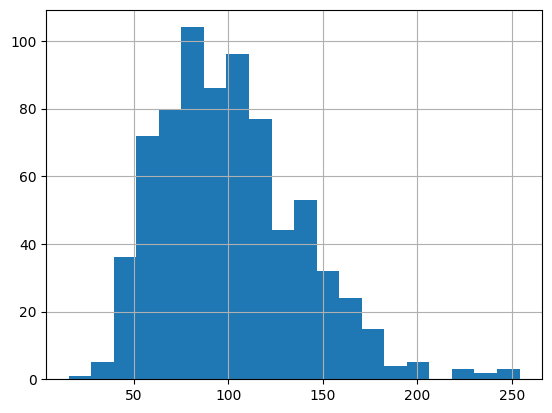

In [400]:
df['Avg Salary(K)'].hist(bins=20)

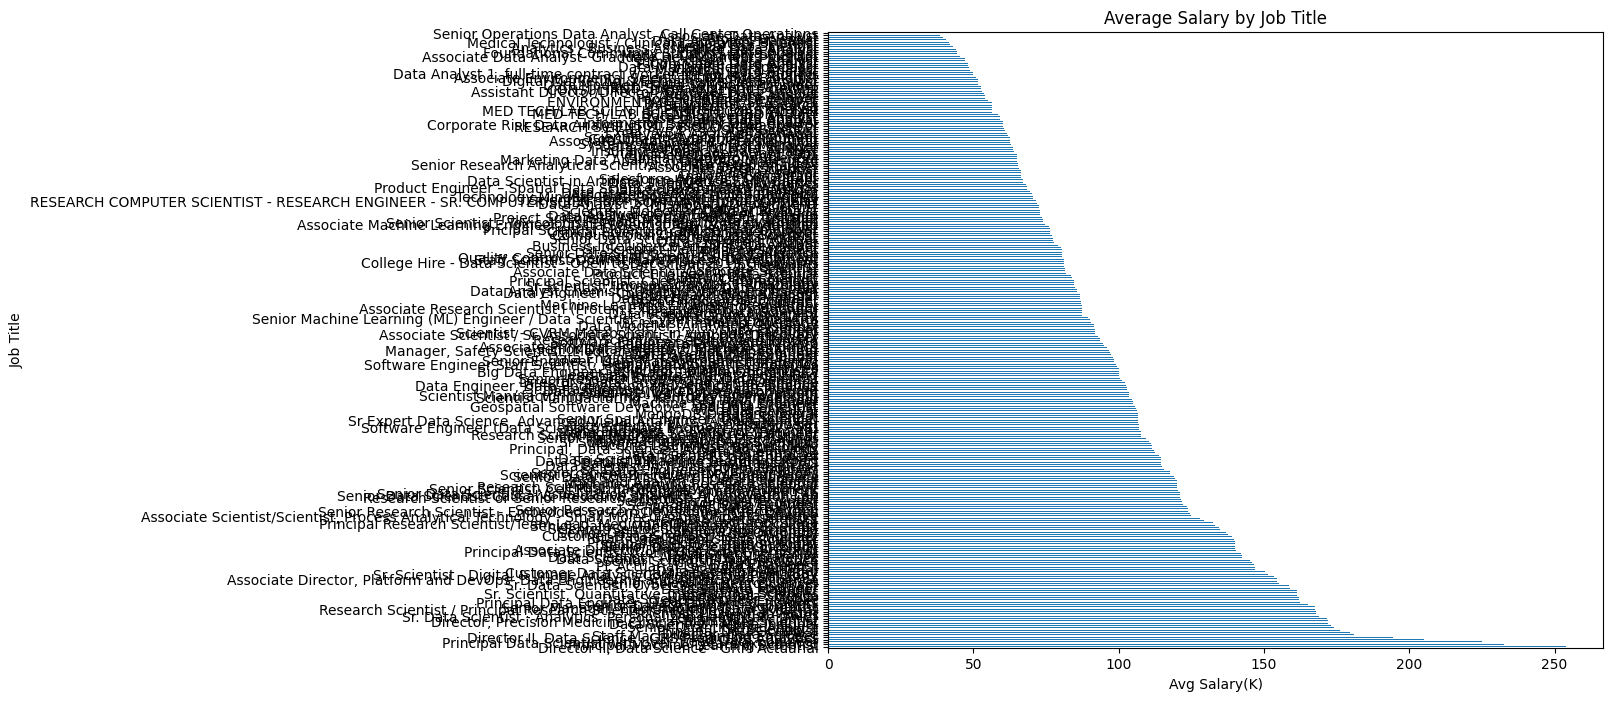

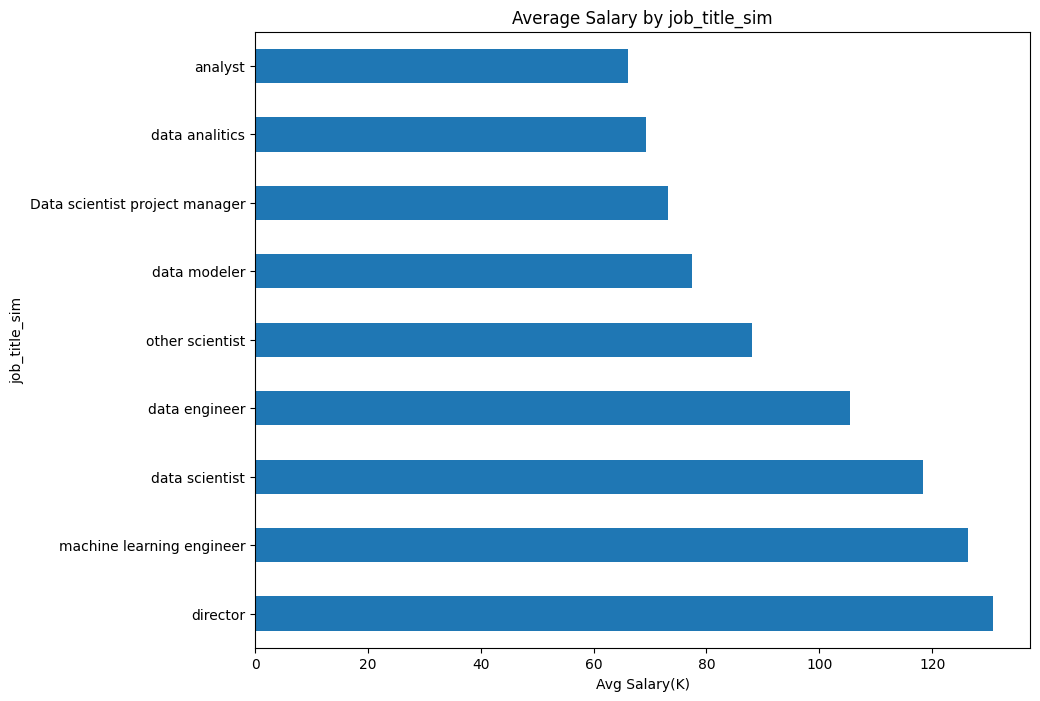

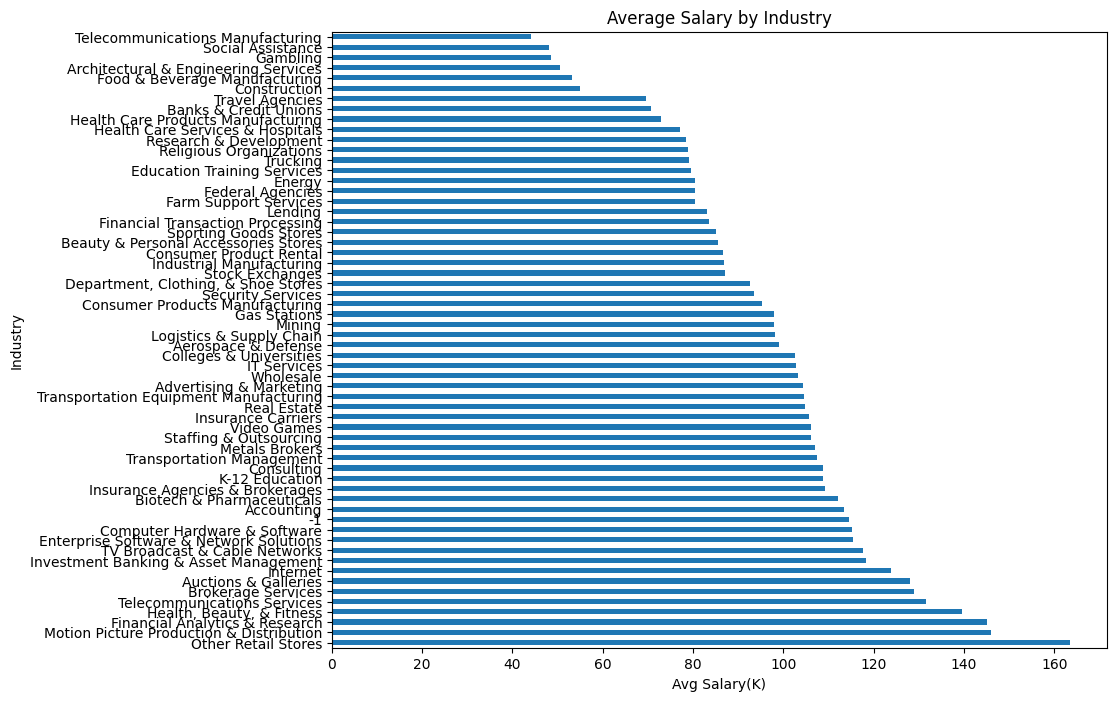

) missing from font(s) DejaVu Sans.rograms\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


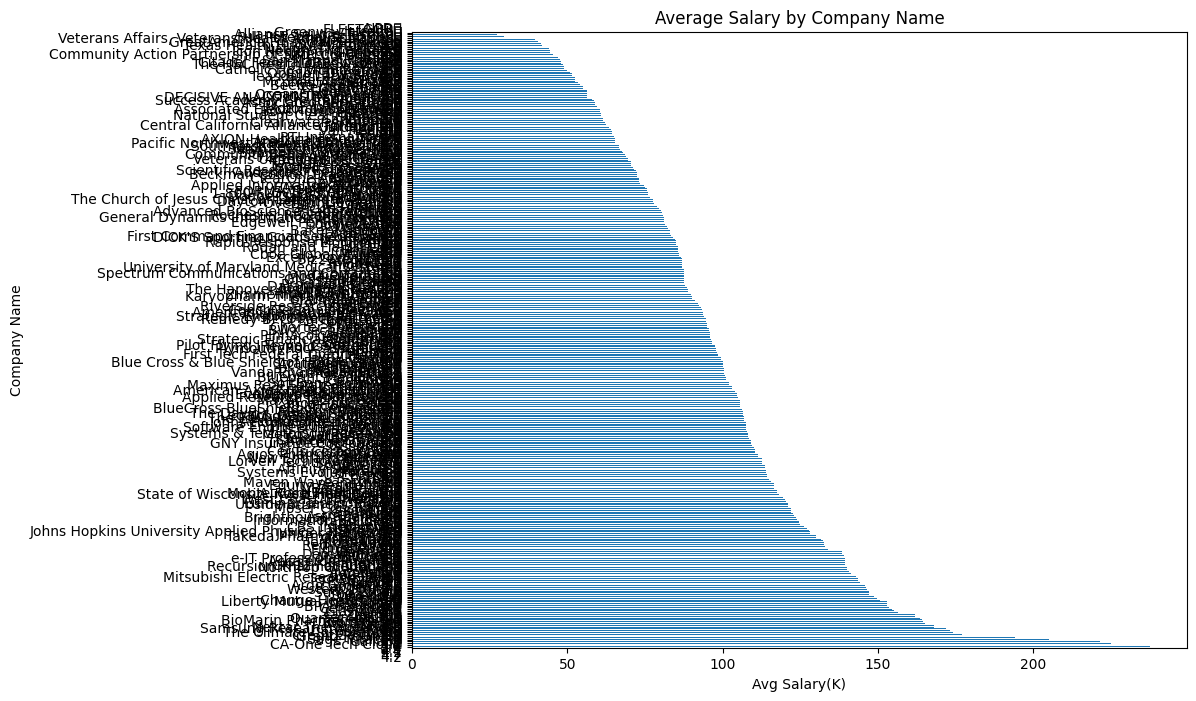

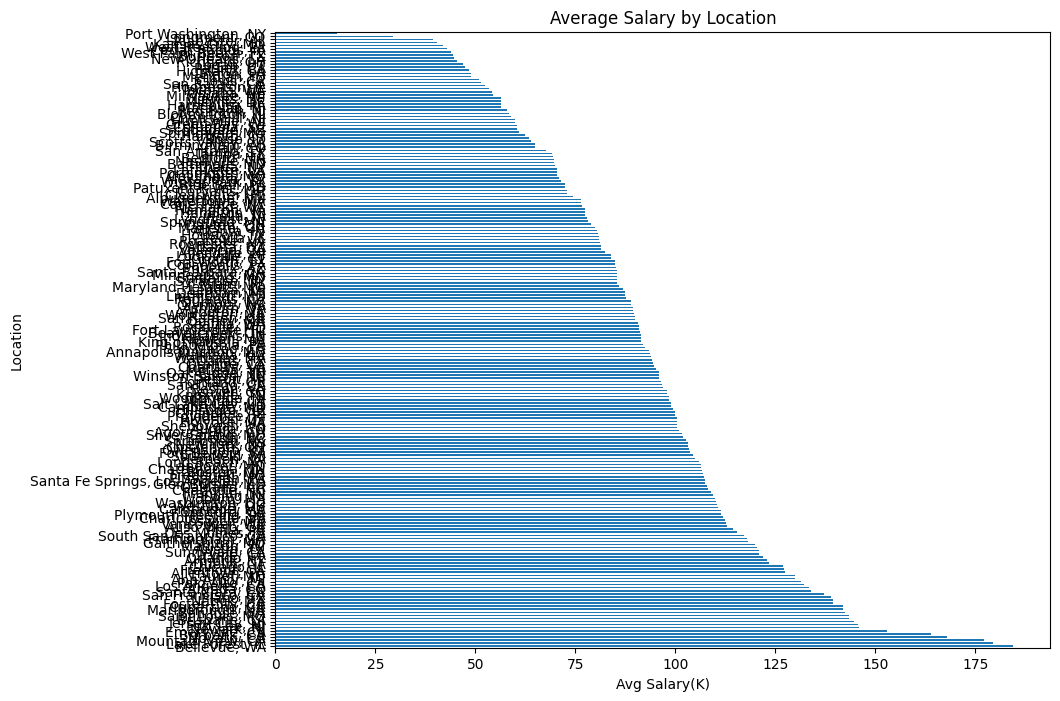

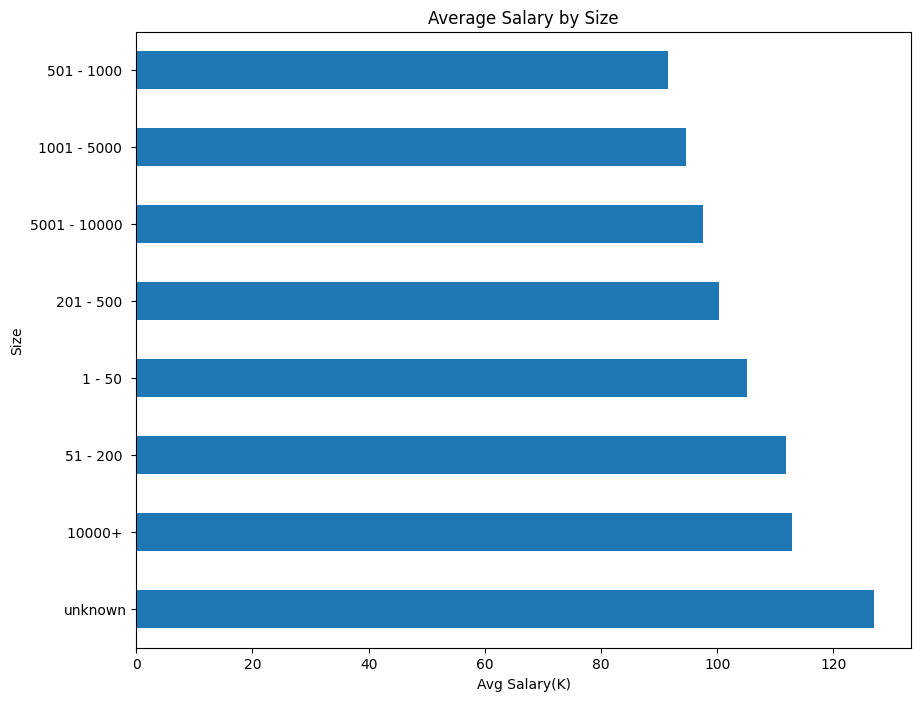

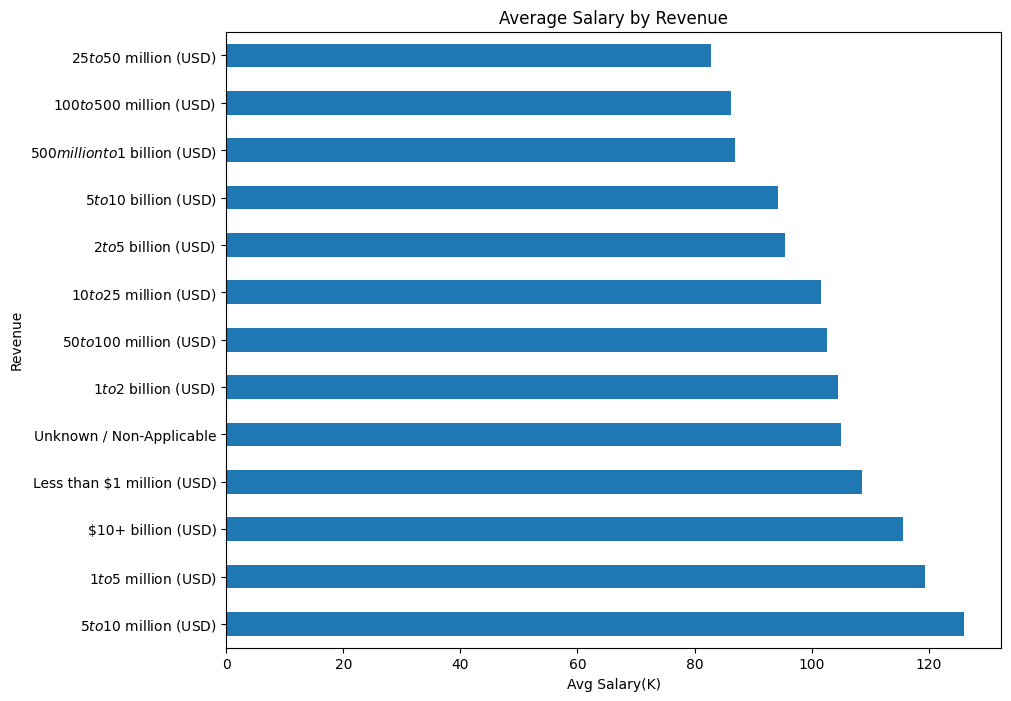

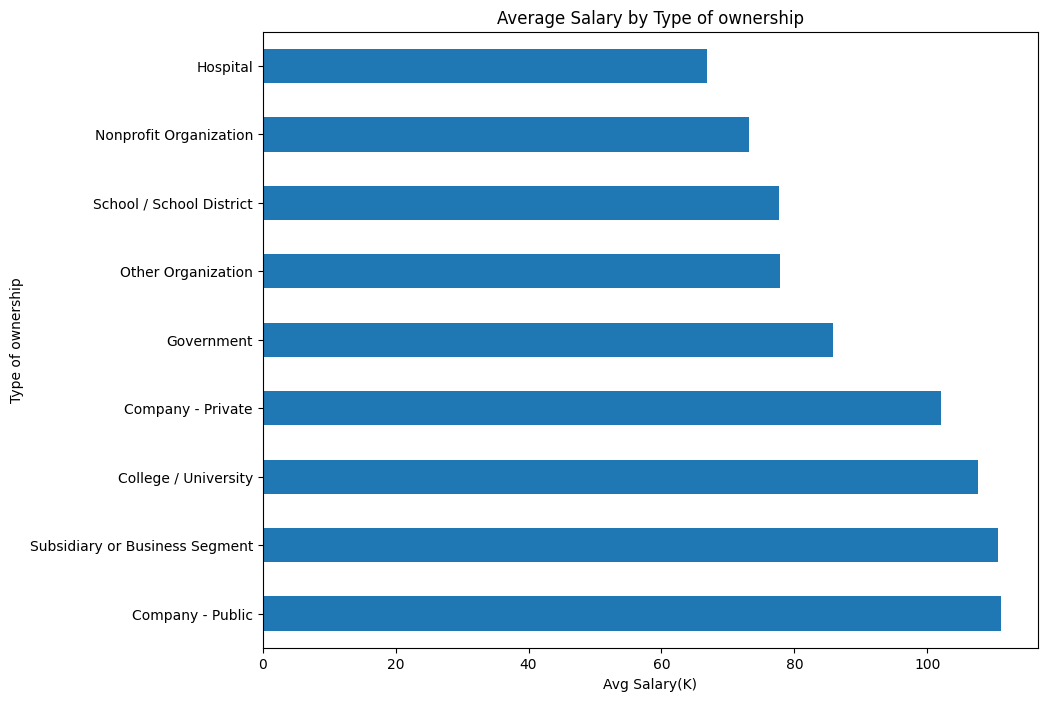

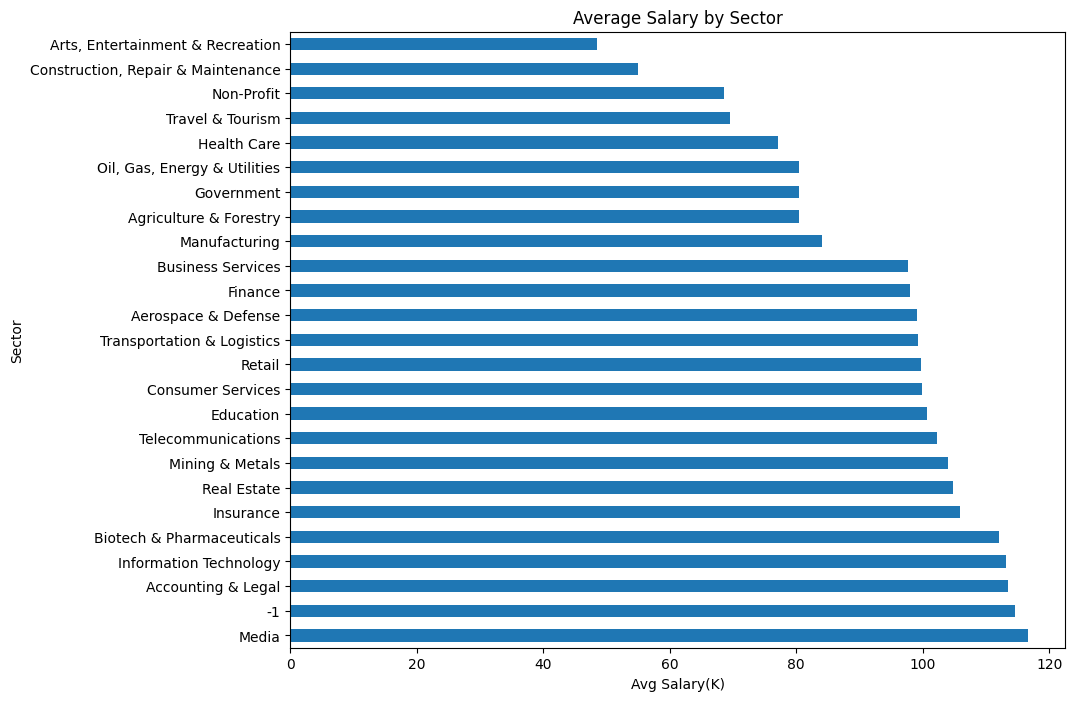

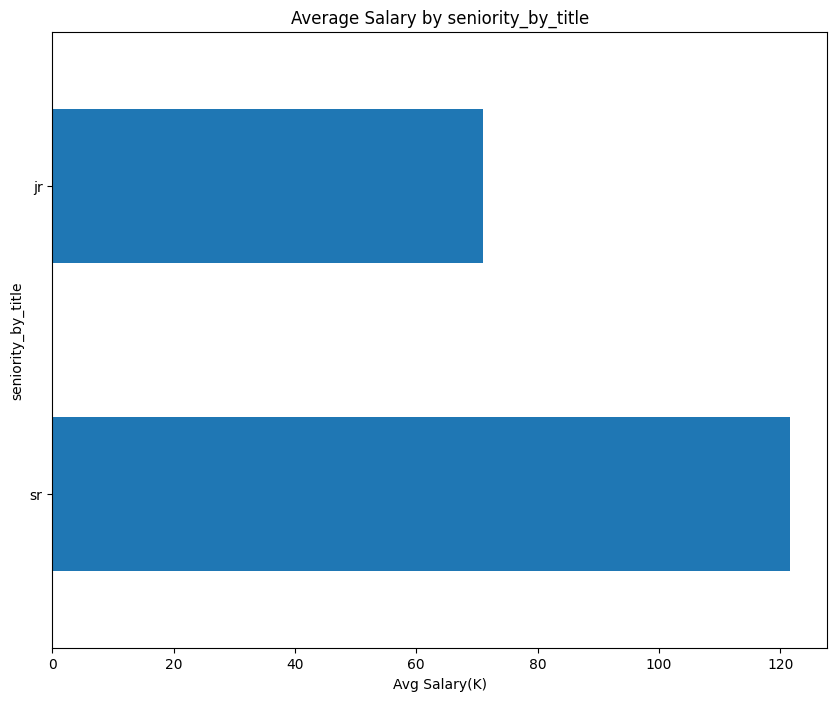

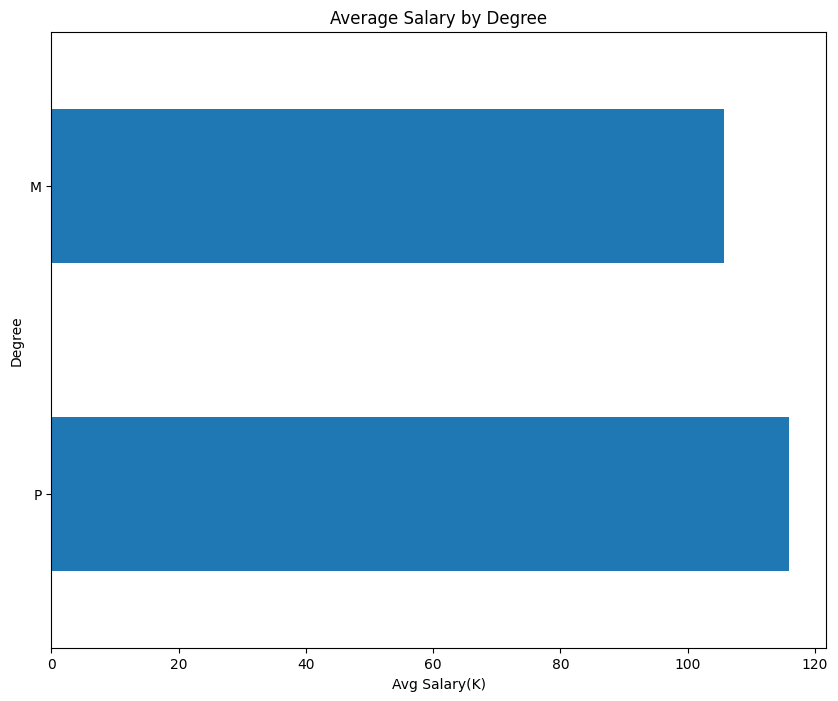

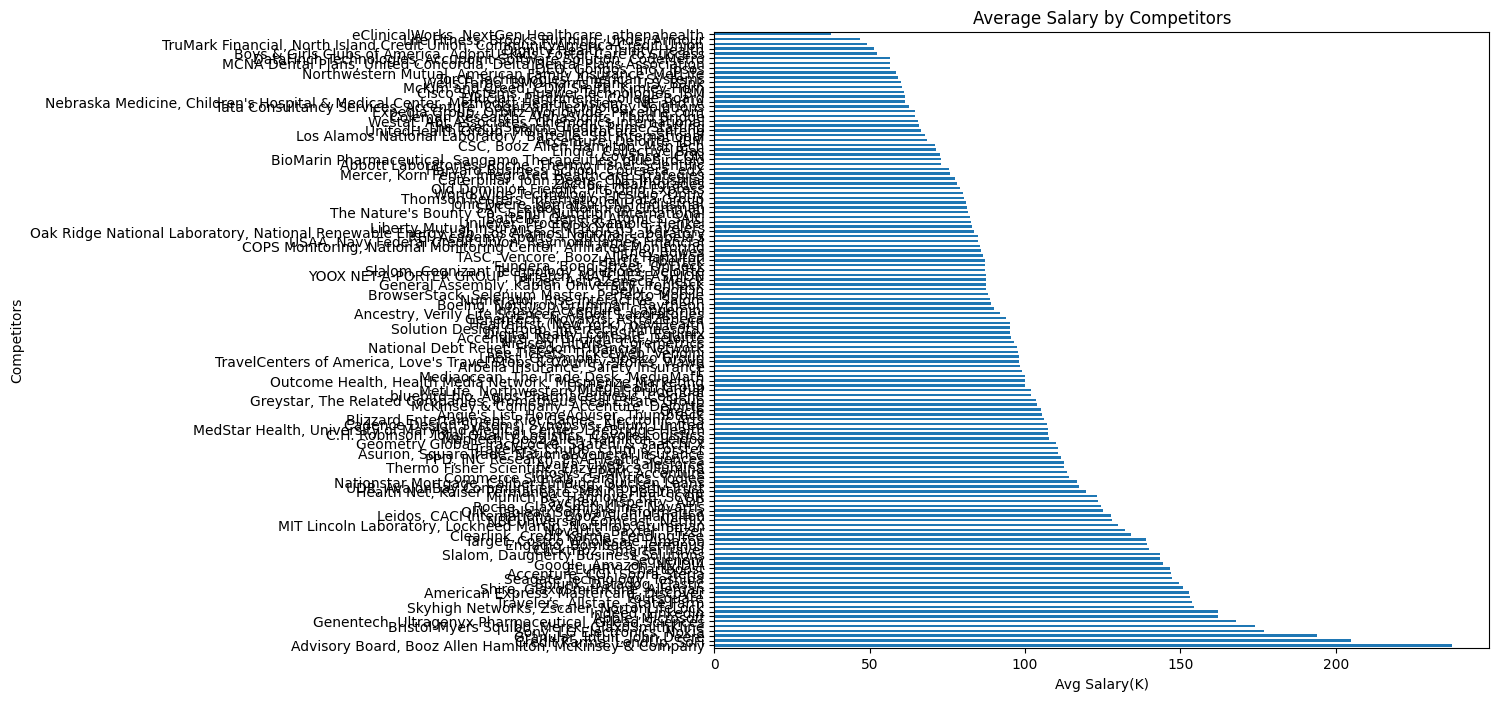

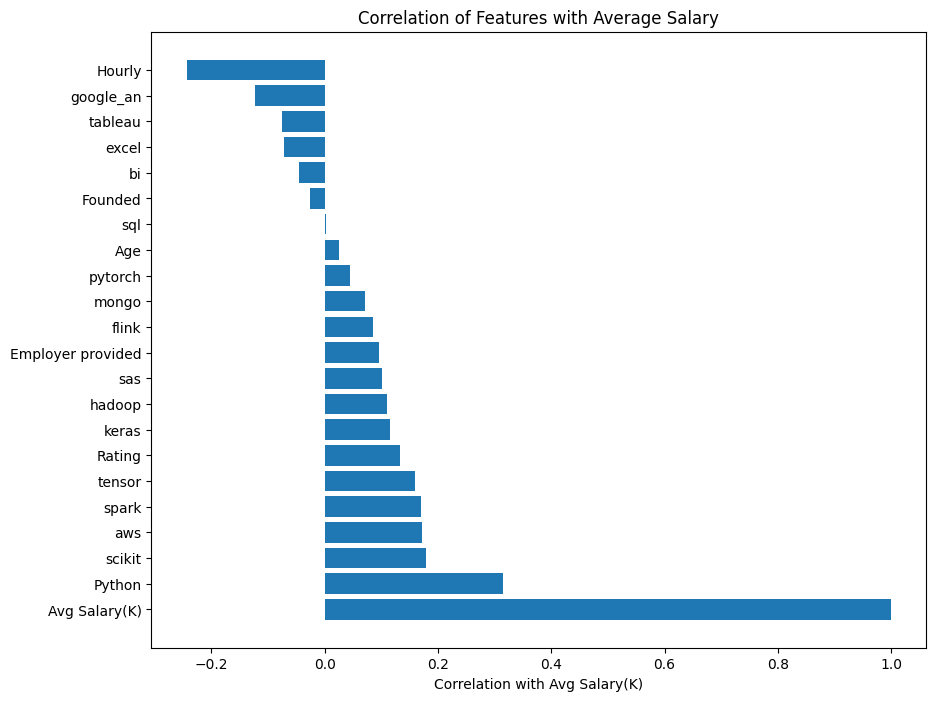

In [401]:
def plot_avg_salary_by_category(df, category_col):
    avg_salary = df.groupby(category_col)['Avg Salary(K)'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    avg_salary.plot(kind='barh')
    plt.title(f'Average Salary by {category_col}')
    plt.xlabel('Avg Salary(K)')
    plt.show()

category_columns = ['Job Title', 'job_title_sim', 'Industry', 'Company Name', 'Location', 'Size', 'Revenue', 'Type of ownership', 'Sector', 'seniority_by_title', 'Degree', 'Competitors']

for category in category_columns:
    plot_avg_salary_by_category(df, category)


skill_columns = ['Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras', 'pytorch',
                 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an']

# Ter certeza de que as colunas de habilidades são do tipo int
df[skill_columns] = df[skill_columns].fillna(0).astype(int)

# Adicionar essas colunas numéricas à análise
df_corr = df[['Avg Salary(K)', 'Rating', 'Founded', 'Age', 'Employer provided', 'Hourly'] + skill_columns]

# Calcular correlação e ordenar
correlation = df_corr.corr()
corr_with_salary = correlation['Avg Salary(K)'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(corr_with_salary.index, corr_with_salary.values)
plt.xlabel('Correlation with Avg Salary(K)')
plt.title('Correlation of Features with Average Salary')
plt.show()


## Pré-processamento e limpeza

In [467]:
# Colunas numéricas, binárias, ordinais e categóricas
num_cols = [
    'Rating',
    'Founded',
    'Age'
]
bin_cols = [
    'Hourly',
    'Employer provided',
    'Python',
    'spark',
    'aws',
    'excel',
    'sql',
    'sas',
    'keras',
    'pytorch',
    'scikit',
    'tensor',
    'hadoop',
    'tableau',
    'bi',
    'flink',
    'mongo',
    'google_an'
]
ord_cols = [
    'Size',  # faixas de funcionários (1-50, 51-200, ...)
    'seniority_by_title',
    'Degree'        
]
cat_cols = [
    'company_txt',
    'Location',
    'Headquarters',
    'Type of ownership',
    'Industry',
    'Sector',
    'Revenue',
    'job_title_sim',
    # 'Job Description',
    # 'Job Location'
]
txt_cols = [
    'Job Description'
]

# Colunas a remover (irrelevantes ou derivadas do target)
drop_cols = [
    'index',            # Índice não é uma feature relevante
    'Salary Estimate',  
    'Lower Salary',     
    'Upper Salary',     
    'Avg Salary(K)',    
    'Job Title',       
    # 'Job Description',  
    'Job Location',     
    'Company Name',     # Faz o mesmo que company_txt
    'Competitors'
]

features = df.drop(columns=drop_cols)
target = df['Avg Salary(K)']


num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# txt_pipe = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='')),
#     ('squeeze', FunctionTransformer(lambda x: x.ravel(), validate=False)),
#     ('tfidf',  TfidfVectorizer(max_features=3000))
# ])

txt_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('squeeze', FunctionTransformer(lambda x: x.ravel(), validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
    ('svd', TruncatedSVD(n_components=400, random_state=42))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    # ('bin', bin_pipe, bin_cols),
    ('ord', ord_pipe, ord_cols),
    ('cat', cat_pipe, cat_cols),
    # ('txt', txt_pipe, txt_cols)
])

In [468]:
results = []
n_total = len(df)
for col in bin_cols:
    n_1 = df[col].sum()
    n_0 = n_total - n_1
    mean_1 = df.loc[df[col] == 1, 'Avg Salary(K)'].mean() if n_1 else None
    mean_0 = df.loc[df[col] == 0, 'Avg Salary(K)'].mean() if n_0 else None
    diff = mean_1 - mean_0 if mean_1 is not None and mean_0 is not None else None

    results.append({
        'feature': col,
        'count_1': n_1,
        'count_0': n_0,
        'pct_1': n_1 / n_total,
        'mean_if_1': mean_1,
        'mean_if_0': mean_0,
        'mean_diff': diff
    })

summary = pd.DataFrame(results) \
    .sort_values(by='pct_1', ascending=False) \
    .reset_index(drop=True)

summary

,feature,count_1,count_0,pct_1,mean_if_1,mean_if_0,mean_diff
0,Python,392,350,0.528302,112.653061,88.975714,23.677347
1,excel,388,354,0.522911,98.896907,104.320621,-5.423714
2,sql,380,362,0.512129,101.557895,101.407459,0.150436
3,aws,176,566,0.237197,113.082386,97.878092,15.204294
4,spark,167,575,0.225067,113.347305,98.039130,15.308175
5,tableau,148,594,0.199461,95.875000,102.882155,-7.007155
6,hadoop,124,618,0.167116,110.729839,99.629450,11.100389
7,tensor,72,670,0.097035,119.777778,99.518657,20.259121
8,sas,66,676,0.088949,113.704545,100.291420,13.413125
9,bi,56,686,0.075472,95.651786,101.960641,-6.308856


In [469]:
# # 1. Ajuste o seu preprocessor nos dados brutos
# preprocessor.fit(features)

# # 2. Extraia todos os nomes de feature já transformados
# all_feature_names = preprocessor.get_feature_names_out()

# # 3. Conte quantos vêm da parte categórica
# #    (total menos numéricas, binárias e ordinais)
# n_num = len(num_cols)
# n_bin = len(bin_cols)
# n_ord = len(ord_cols)
# n_all = len(all_feature_names)
# n_cat = n_all - (n_num + n_bin + n_ord)

# print(f"Total de features após transformação: {n_all}")
# print(f"- Numéricas: {n_num}")
# print(f"- Binárias:   {n_bin}")
# print(f"- Ordinais:   {n_ord}")
# print(f"- One-Hot:    {n_cat}")

# txt_pipe.fit(features[['Job Description']])

# # 2. Acesse o TF‑IDF e veja o tamanho do vocabulário
# tfidf: TfidfVectorizer = txt_pipe.named_steps['tfidf']
# n_terms = len(tfidf.vocabulary_)

# print(f"Se não limitasse, o TF‑IDF geraria {n_terms} features (termos).")

## Seleção de features

In [470]:
# Método Filter
# skbest = SelectKBest(score_func=f_regression, k=1009)

# Método Wrapper
# est_base = LinearRegression()
# est_base = LassoCV(cv=5, random_state=42, max_iter=5000)
# est_base = Lasso(random_state=42)
est_base = Ridge(random_state=42)

rfecv = RFECV(
    estimator=est_base,
    step=30, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

to_dense = FunctionTransformer(
    func=lambda X: X.toarray() if hasattr(X, "toarray") else X,
    validate=False
)

# Pipeline sequencial: KBest ➔ RFECV
pipeline_seq = Pipeline([
    ('preprocessor', preprocessor),
    # ('kbest', skbest),
    ('rfecv', rfecv),
    ('to_dense', to_dense)
])

## Treinamento e teste

### Função de treinamento

In [471]:
def train_and_evaluate(pipeline, estimator, param_grid, 
                    X_train, y_train, X_test, y_test):

    """
    Combina pipeline (pré-processamento + seleção) com modelo,
    executa GridSearchCV e retorna grid e métricas de teste.
    """

    full_pipe = Pipeline([('pipe', pipeline),
                          ('model', estimator)])
    
    # Constrói o param_grid para GridSearchCV
    gs_params = {}
    for key, values in param_grid.items():
        if '__' in key:
            # parãmetro de pipeline (como 'kbest__k')
            gs_params[f'pipe__{key}'] = values
        else:
            # parâmetro do estimador (como 'alpha')
            gs_params[f'model__{key}'] = values

    grid = GridSearchCV(
        full_pipe,
        param_grid=gs_params,
        cv=5 ,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    
    # Previsão com melhor modelo encontrado
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    
    # Cálculo de métricas
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    return {        
        'best_estimator': best_estimator,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'cv_results': grid.cv_results_,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,        
        'r2': r2
    }

In [472]:
def nested_cv_evaluate(pipeline, estimator, param_grid,
                       X, y, outer_folds=5, inner_folds=3,
                       scoring='r2'):
    """
    Executa nested CV:
      - GridSearchCV interno em inner_folds
      - cross_val_score externo em outer_folds
    Retorna array de scores externos.
    """
    full_pipe = Pipeline([('pipe', pipeline), 
                          ('model', estimator)])

    # prefixa parâmetros
    gs_params = {}
    for key, vals in param_grid.items():
        if '__' in key:
            gs_params[f'pipe__{key}'] = vals
        else:
            gs_params[f'model__{key}'] = vals

    # GridSearch interno
    inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    grid = GridSearchCV(
        full_pipe,
        param_grid=gs_params,
        cv=inner_cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    # Avaliação externa
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=1)
    scores = cross_val_score(
        grid, 
        X, y,
        cv=outer_cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    return scores

### Divisão do dataset em treino e teste

In [455]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Execução dos modelos

#### Ridge

In [473]:
# Regressão Linear com regularização L1
estimator_ridge = Lasso(random_state=42)

param_grid_ridge = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

result_ridge = train_and_evaluate(
    pipeline_seq,
    estimator_ridge,
    param_grid_ridge,
    X_train, 
    y_train,
    X_test,   
    y_test
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


#### DecisionTree

In [474]:
estimator_dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {    
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1]
}

result_dt = train_and_evaluate(
    pipeline_seq,
    estimator_dt,
    param_grid_dt,
    X_train, 
    y_train,
    X_test,  
    y_test
)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


#### RandomForest

In [475]:
estimator_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200, 400],         # Número de árvores na floresta
    'max_depth': [5, 10, None],           # Profundidade máxima das árvores
    'min_samples_split': [2, 5],        # Número mínimo de amostras necessárias para dividir um nó      
    'max_features': ['sqrt', 'log2', None], # Número de recursos a serem considerados ao procurar a melhor divisão
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]         # Parâmetro de complexidade para poda   
}

result_rf = train_and_evaluate(
    pipeline_seq,
    estimator_rf,
    param_grid_rf,
    X_train, 
    y_train,
    X_test,  
    y_test
)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


#### XGBoost

In [476]:
estimator_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid_xgb = {
    'n_estimators': [50, 100, 300, 500, 700, 900],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10, None],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6]    
}

result_xgb = train_and_evaluate(
    pipeline_seq,
    estimator_xgb,
    param_grid_xgb,
    X_train, 
    y_train,
    X_test,   
    y_test
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


#### GradientBoostingRegressor

In [477]:
estimator_gbr = GradientBoostingRegressor(random_state=42)

param_grid_gbr = {
  'n_estimators':     [50, 100, 300, 500, 700, 900],
  'learning_rate':    [0.01, 0.05, 0.1, 0.2, 0.3],
  'max_depth':      [5, 7, 10, None],
  'subsample':        [0.6, 0.8, 1.0]
}

result_gbr  = train_and_evaluate(
    pipeline_seq,
    estimator_gbr,
    param_grid_gbr,
    X_train, 
    y_train,
    X_test, 
    y_test
)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


## Resultados

### Melhores combinações de hiperparâmetros

In [23]:
# Imprime melhores parâmetros, melhor score e top N combos de hiperparâmetros
def print_search_results(result, model_name, top_n=20):
    print(
        f"Modelo {model_name} \n\n"
        f"Melhores parâmetros: {result['best_params']} \n"
        f"Melhor score médio: {result['best_score']:.4f} \n\n"
        f"Top {top_n} combinações de hiperparâmetros:"
    )
    df = pd.DataFrame(result['cv_results'])
    display(df.sort_values(by='mean_test_score', ascending=False).head(top_n))

#### Ridge

In [283]:
print_search_results(result_ridge, "Ridge")

Modelo Ridge 

Melhores parâmetros: {'model__alpha': 0.001} 
Melhor score médio: 0.6355 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,43.720497,0.904338,0.437907,0.077984,0.0010,{'model__alpha': 0.001},0.561705,0.706417,0.660590,0.548076,0.700585,0.635475,0.067799,1
2,41.473967,4.549656,1.285120,0.957802,0.0100,{'model__alpha': 0.01},0.520736,0.686075,0.658650,0.554758,0.711600,0.626364,0.075043,2
0,43.772358,2.751305,0.444257,0.110787,0.0001,{'model__alpha': 0.0001},0.541619,0.600429,0.655811,0.546991,0.639956,0.596961,0.046655,3
3,38.490538,3.404319,1.242902,0.927356,0.1000,{'model__alpha': 0.1},0.451411,0.496611,0.492254,0.459173,0.527624,0.485415,0.027563,4
4,38.881387,4.339229,0.770292,0.221103,1.0000,{'model__alpha': 1.0},0.243597,0.292213,0.316688,0.250533,0.306586,0.281923,0.029587,5
5,38.561997,3.370594,0.984820,0.375008,5.0000,{'model__alpha': 5.0},0.079328,0.080508,0.050135,0.001024,0.073351,0.056869,0.029996,6
6,40.358731,2.352134,0.650901,0.245257,10.0000,{'model__alpha': 10.0},-0.010997,-0.000077,-0.023100,-0.001809,-0.000384,-0.007274,0.008871,7
7,32.514210,4.600400,0.586950,0.082416,20.0000,{'model__alpha': 20},-0.010997,-0.000077,-0.023100,-0.001809,-0.000384,-0.007274,0.008871,7
8,27.016911,0.928440,0.239204,0.200668,100.0000,{'model__alpha': 100.0},-0.010997,-0.000077,-0.023100,-0.001809,-0.000384,-0.007274,0.008871,7


#### DecisionTree

In [54]:
print_search_results(result_dt, "DecisionTree")

Modelo DecisionTree 

Melhores parâmetros: {'model__ccp_alpha': 0.1, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2} 
Melhor score médio: 0.4959 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
122,2.602606,0.326543,0.092118,0.058215,0.100,None,sqrt,2,"{'model__ccp_alpha': 0.1, 'model__max_depth': ...",0.335691,0.546857,0.523574,0.502872,0.570320,0.495863,0.083206,1
90,2.016391,0.303950,0.052354,0.010331,0.010,None,sqrt,2,"{'model__ccp_alpha': 0.01, 'model__max_depth':...",0.328057,0.550657,0.523502,0.503431,0.565146,0.494158,0.085753,2
26,2.094163,0.311359,0.051406,0.016960,0.000,None,sqrt,2,"{'model__ccp_alpha': 0.0, 'model__max_depth': ...",0.327352,0.550853,0.523502,0.503431,0.564749,0.493977,0.085987,3
58,1.928462,0.272282,0.051557,0.011563,0.001,None,sqrt,2,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.327343,0.550611,0.523502,0.503431,0.564749,0.493927,0.085958,4
154,1.977103,0.306616,0.043159,0.007342,1.000,None,sqrt,2,"{'model__ccp_alpha': 1, 'model__max_depth': No...",0.330613,0.508525,0.507658,0.503628,0.547711,0.479627,0.076207,5
56,2.095595,0.271403,0.048501,0.007316,0.001,None,None,2,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.337894,0.417724,0.517912,0.483577,0.588392,0.469100,0.085647,6
24,2.093297,0.252961,0.058052,0.009956,0.000,None,None,2,"{'model__ccp_alpha': 0.0, 'model__max_depth': ...",0.338010,0.417142,0.517849,0.483369,0.588902,0.469055,0.085810,7
88,1.982077,0.252658,0.053241,0.006735,0.010,None,None,2,"{'model__ccp_alpha': 0.01, 'model__max_depth':...",0.336116,0.413147,0.517826,0.483232,0.590208,0.468106,0.087237,8
120,3.283256,0.235414,0.103510,0.117221,0.100,None,None,2,"{'model__ccp_alpha': 0.1, 'model__max_depth': ...",0.334758,0.413401,0.517761,0.483666,0.584033,0.466724,0.085920,9
123,2.354605,0.343190,0.071980,0.034331,0.100,None,sqrt,5,"{'model__ccp_alpha': 0.1, 'model__max_depth': ...",0.332905,0.543682,0.411206,0.499953,0.503292,0.458208,0.076146,10


#### RandomForest

In [62]:
print_search_results(result_rf, "RandomForest")

Modelo RandomForest 

Melhores parâmetros: {'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_split': 2, 'model__n_estimators': 200} 
Melhor score médio: 0.5778 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,2.623105,0.253650,0.056754,0.020439,0.000,None,log2,2,200,"{'model__ccp_alpha': 0.0, 'model__max_depth': ...",0.559291,0.625236,0.539295,0.501535,0.663831,0.577838,0.058810,1
50,2.919544,0.172188,0.081073,0.027160,0.001,None,log2,2,200,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.559289,0.625227,0.539294,0.501531,0.663823,0.577833,0.058807,2
86,2.940417,0.166952,0.071058,0.015971,0.010,None,log2,2,200,"{'model__ccp_alpha': 0.01, 'model__max_depth':...",0.559265,0.625231,0.539278,0.501534,0.663794,0.577820,0.058803,3
122,3.181582,0.201519,0.067558,0.017820,0.100,None,log2,2,200,"{'model__ccp_alpha': 0.1, 'model__max_depth': ...",0.559023,0.625058,0.539143,0.501382,0.664157,0.577752,0.058953,4
3,4.592454,0.688639,0.115944,0.031624,0.000,None,sqrt,2,400,"{'model__ccp_alpha': 0.0, 'model__max_depth': ...",0.549000,0.633744,0.535693,0.497957,0.670943,0.577467,0.064470,5
39,3.267487,0.332449,0.071499,0.006455,0.001,None,sqrt,2,400,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.549003,0.633736,0.535690,0.497957,0.670941,0.577465,0.064469,6
75,3.528864,0.391580,0.085616,0.015094,0.010,None,sqrt,2,400,"{'model__ccp_alpha': 0.01, 'model__max_depth':...",0.549024,0.633736,0.535672,0.497951,0.670935,0.577464,0.064469,7
111,3.509637,0.402759,0.088992,0.011449,0.100,None,sqrt,2,400,"{'model__ccp_alpha': 0.1, 'model__max_depth': ...",0.548678,0.633963,0.535618,0.497924,0.670775,0.577392,0.064507,8
5,8.197227,1.275762,0.284552,0.110271,0.000,None,sqrt,2,800,"{'model__ccp_alpha': 0.0, 'model__max_depth': ...",0.551953,0.634825,0.529504,0.499553,0.668042,0.576775,0.064052,9
41,5.724599,1.189767,0.211417,0.048939,0.001,None,sqrt,2,800,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.551956,0.634820,0.529502,0.499552,0.668042,0.576774,0.064052,10


#### XGBoost

In [33]:
print_search_results(result_xgb, "XGBoost")

Modelo XGBoost 

Melhores parâmetros: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__subsample': 1.0} 
Melhor score médio: 0.5898 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
171,2.348350,0.150235,0.080052,0.028111,0.6,0.20,10,100,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.565334,0.641018,0.545790,0.485721,0.711114,0.589796,0.078368,1
169,2.280724,0.202310,0.064843,0.009579,0.6,0.20,10,50,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.567657,0.636178,0.544774,0.499809,0.697968,0.589277,0.069951,2
115,3.111519,0.469202,0.064757,0.026500,0.6,0.10,7,500,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.573754,0.641468,0.517325,0.475035,0.733208,0.588158,0.091546,3
113,3.282231,0.376662,0.072432,0.016996,0.6,0.10,7,300,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.577307,0.642478,0.514582,0.483335,0.722990,0.588138,0.086775,4
117,3.226361,0.605565,0.076422,0.038145,0.6,0.10,7,700,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.572609,0.642465,0.517419,0.472288,0.735462,0.588049,0.093080,5
119,3.695764,1.116004,0.088996,0.061730,0.6,0.10,7,900,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.569849,0.643042,0.515953,0.470071,0.735035,0.586790,0.093882,6
139,2.810375,0.383663,0.074901,0.035104,0.6,0.10,None,500,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.583214,0.623899,0.511492,0.482968,0.723612,0.585037,0.085491,7
95,3.013282,0.648480,0.061636,0.020030,0.6,0.05,None,900,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.580462,0.627680,0.519913,0.481532,0.710804,0.584078,0.080755,8
141,2.934880,0.498030,0.059206,0.022019,0.6,0.10,None,700,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.576402,0.623851,0.510757,0.480285,0.728809,0.584021,0.088019,9
143,3.330863,0.802801,0.095416,0.085853,0.6,0.10,None,900,1.0,"{'model__colsample_bytree': 0.6, 'model__learn...",0.571789,0.626260,0.511225,0.479121,0.730361,0.583751,0.089053,10


#### GradientBoosting

In [37]:
print_search_results(result_gbr, "GradientBoosting")

Modelo GradientBoosting 

Melhores parâmetros: {'model__learning_rate': 0.2, 'model__max_depth': None, 'model__n_estimators': 500, 'model__subsample': 0.6} 
Melhor score médio: 0.5860 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
279,15.057492,8.982039,0.032413,0.004617,0.20,None,500,0.6,"{'model__learning_rate': 0.2, 'model__max_dept...",0.585543,0.577838,0.520193,0.522078,0.724420,0.586015,0.074355,1
285,22.909990,14.610391,0.043102,0.008262,0.20,None,900,0.6,"{'model__learning_rate': 0.2, 'model__max_dept...",0.583894,0.579326,0.515188,0.526421,0.725071,0.585980,0.074771,2
101,9.147973,4.098864,0.028578,0.003505,0.05,7,500,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.579024,0.592237,0.524118,0.509940,0.724386,0.585941,0.075964,3
310,3.238573,0.666108,0.029790,0.002951,0.30,7,100,0.8,"{'model__learning_rate': 0.3, 'model__max_dept...",0.567239,0.630910,0.520325,0.488396,0.722002,0.585774,0.083313,4
98,7.311957,2.872976,0.029616,0.006104,0.05,7,300,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.574304,0.590554,0.525808,0.520820,0.715694,0.585436,0.070495,5
104,15.879706,7.572615,0.048878,0.013916,0.05,7,700,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.577787,0.592802,0.523303,0.505188,0.725528,0.584921,0.077508,6
170,6.977402,2.850663,0.024676,0.002894,0.10,7,300,1.0,"{'model__learning_rate': 0.1, 'model__max_dept...",0.568763,0.587246,0.526432,0.503224,0.737569,0.584647,0.082052,7
282,17.781955,11.207585,0.033506,0.005449,0.20,None,700,0.6,"{'model__learning_rate': 0.2, 'model__max_dept...",0.573671,0.583316,0.503688,0.533233,0.723267,0.583435,0.075536,8
89,16.638953,8.419485,0.036613,0.006469,0.05,5,900,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.580443,0.621892,0.496067,0.494579,0.722957,0.583188,0.085420,9
107,20.201277,10.507419,0.034128,0.006552,0.05,7,900,1.0,"{'model__learning_rate': 0.05, 'model__max_dep...",0.572159,0.591336,0.521713,0.502932,0.727342,0.583096,0.078979,10


### Medidas de desempenho

In [478]:
def print_metrics(result, model_name):         
        print(
            f"{model_name} → "            
            f"| MAE: {result['mae']:.2f} "
            f"| RMSE: {result['rmse']:.2f} "
            f"| R²: {result['r2']:.4f} |"
        )

for name, result in [
    ("Lasso", result_ridge),
    ("DecisionTree", result_dt),
    ("RandomForest", result_rf),
    ("XGBoost", result_xgb),
    ("GradientBoosting", result_gbr)
]:
    print_metrics(result, name)

Lasso → | MAE: 12.99 | RMSE: 19.09 | R²: 0.7677 |
DecisionTree → | MAE: 10.80 | RMSE: 19.79 | R²: 0.7503 |
RandomForest → | MAE: 12.35 | RMSE: 18.66 | R²: 0.7780 |
XGBoost → | MAE: 11.72 | RMSE: 17.32 | R²: 0.8088 |
GradientBoosting → | MAE: 11.21 | RMSE: 17.23 | R²: 0.8107 |


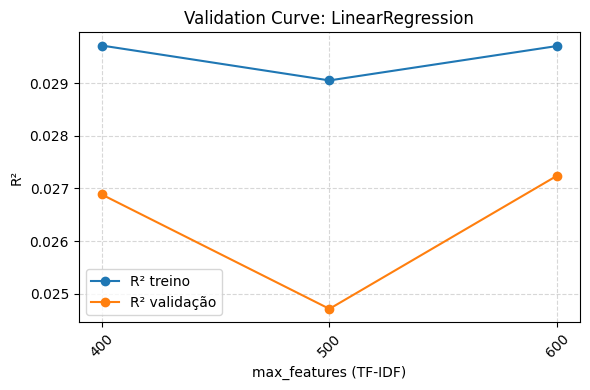

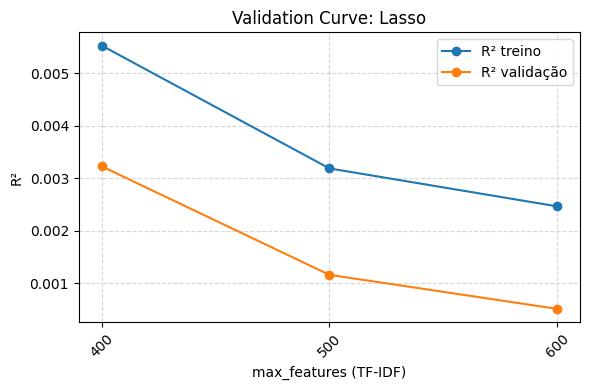

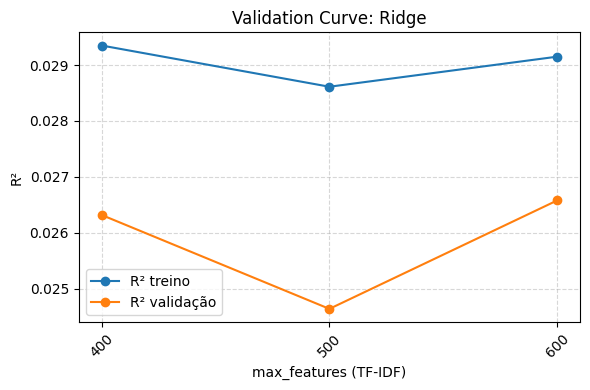

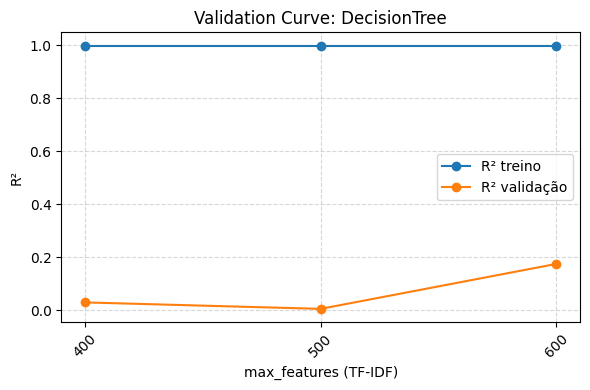

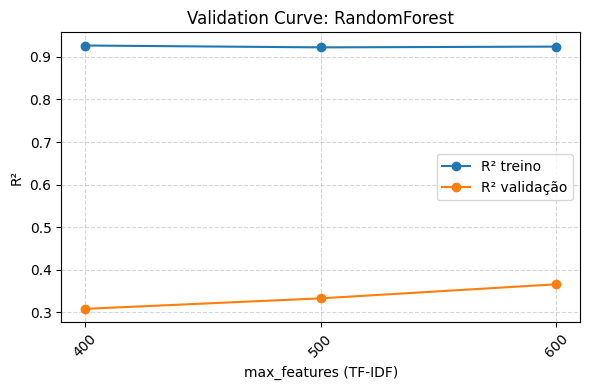

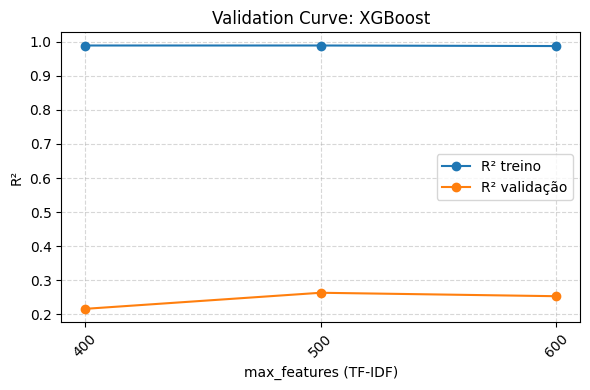

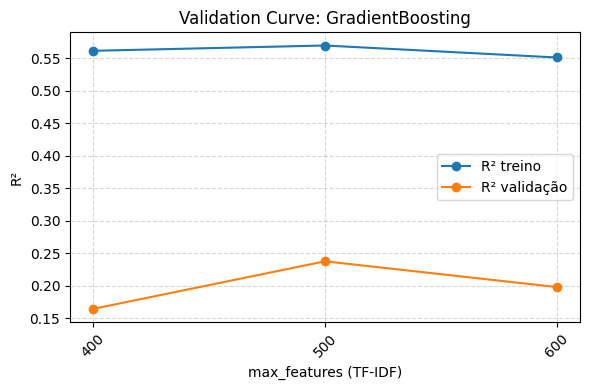

In [464]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

models = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    ('DecisionTree', DecisionTreeRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42, n_jobs=-1)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42))
]

param_range = [400, 500, 600]
# param_range = [100, 400, 1000, 2000, 5000, 10000]

# Iterate and plot separately
for name, estimator in models:
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='')),
        ('squeeze', FunctionTransformer(lambda x: x.ravel(), validate=False)),
        # ('tfidf',   TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
        ('svd',     TruncatedSVD(random_state=42)),
        # ('svd', TruncatedSVD(n_components=400, random_state=42))
        ('model',   estimator)
    ])
    
    train_scores, test_scores = validation_curve(
        pipe, features[['Job Description']], target,
        param_name='tfidf__max_features',
        param_range=param_range,
        cv=5, scoring='r2', n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    test_mean  = test_scores.mean(axis=1)
    
    plt.figure(figsize=(6,4))
    plt.plot(param_range, train_mean, marker='o', label='R² treino')
    plt.plot(param_range, test_mean,  marker='o', label='R² validação')
    plt.xlabel('max_features (TF-IDF)')
    plt.ylabel('R²')
    plt.title(f'Validation Curve: {name}')
    plt.xticks(param_range, rotation=45)
    plt.grid(True, ls='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Gráficos

#### Reais vs Preditos

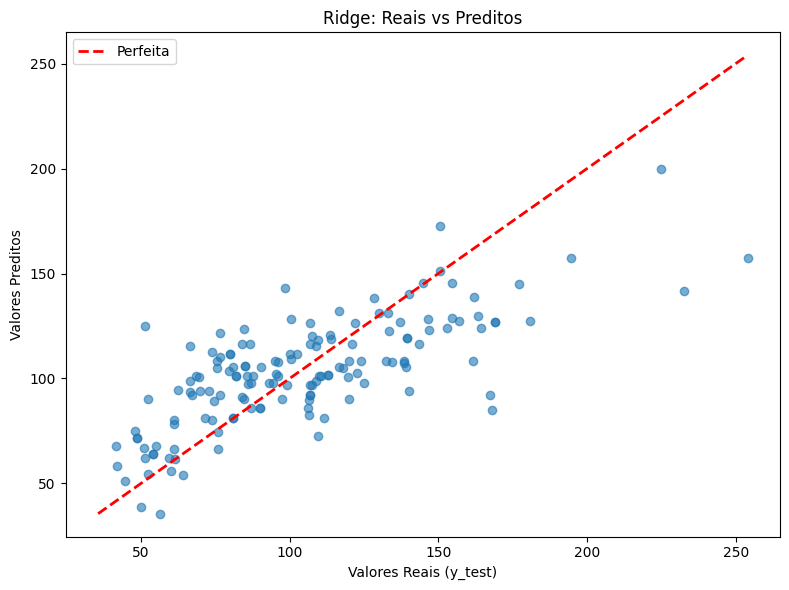

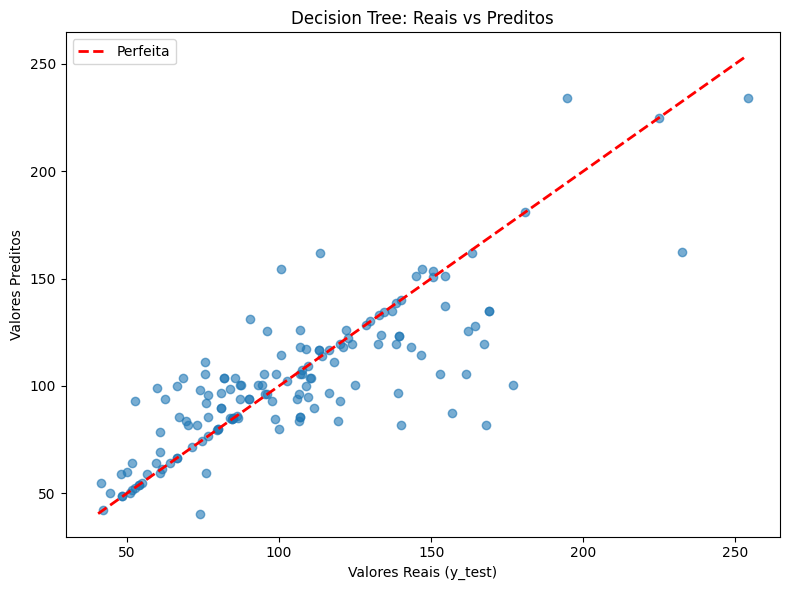

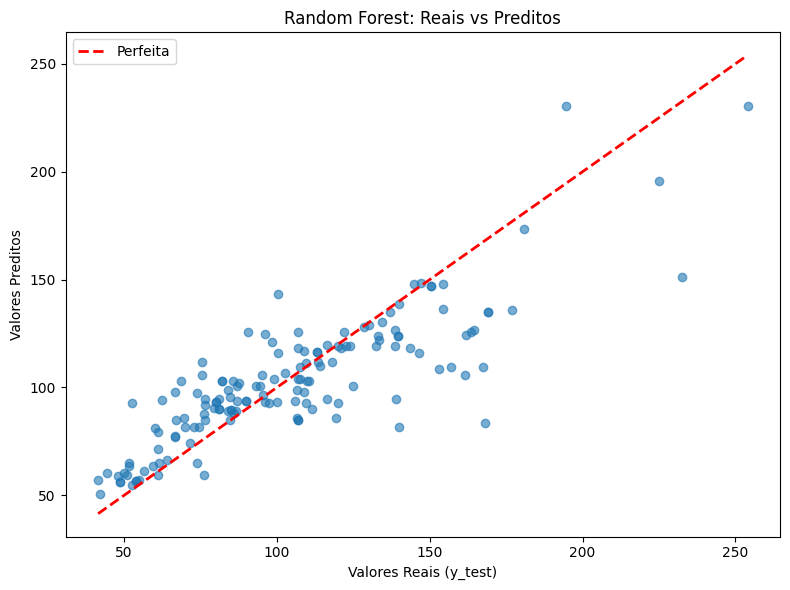

In [16]:
def plot_predicted_vs_actual(result, model_name, y_test):
    y_pred = result['y_pred']
    
    # Scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Linha identidade
    lim_min = min(y_test.min(), y_pred.min())
    lim_max = max(y_test.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', lw=2, label='Perfeita')

    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name}: Reais vs Preditos")
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_predicted_vs_actual(result, name, y_test)

#### Resíduos vs Preditos

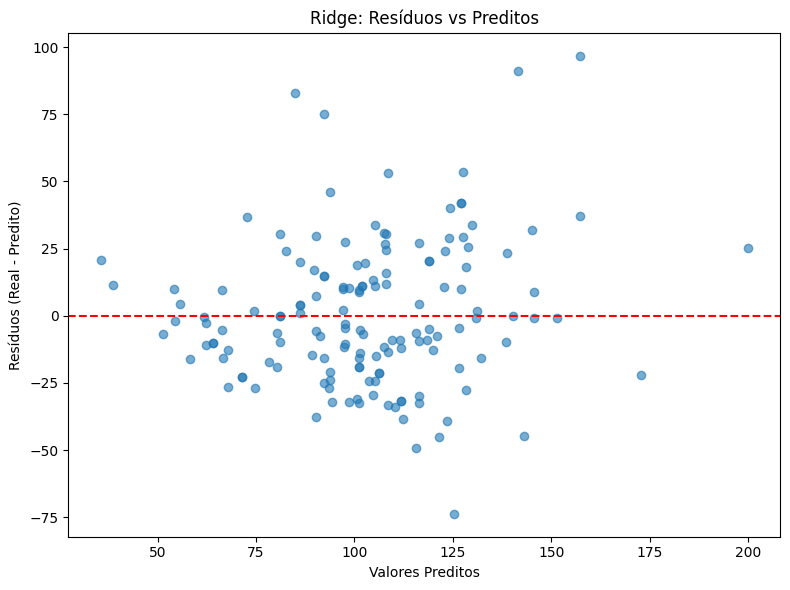

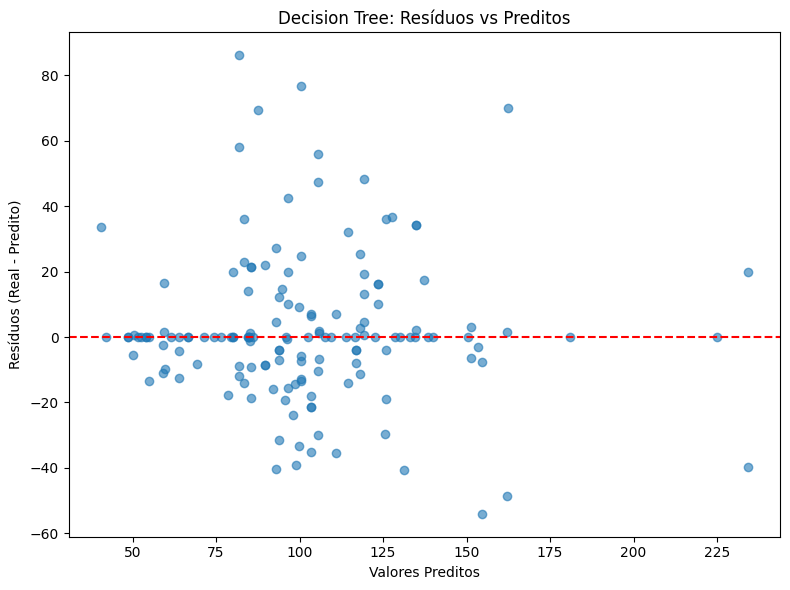

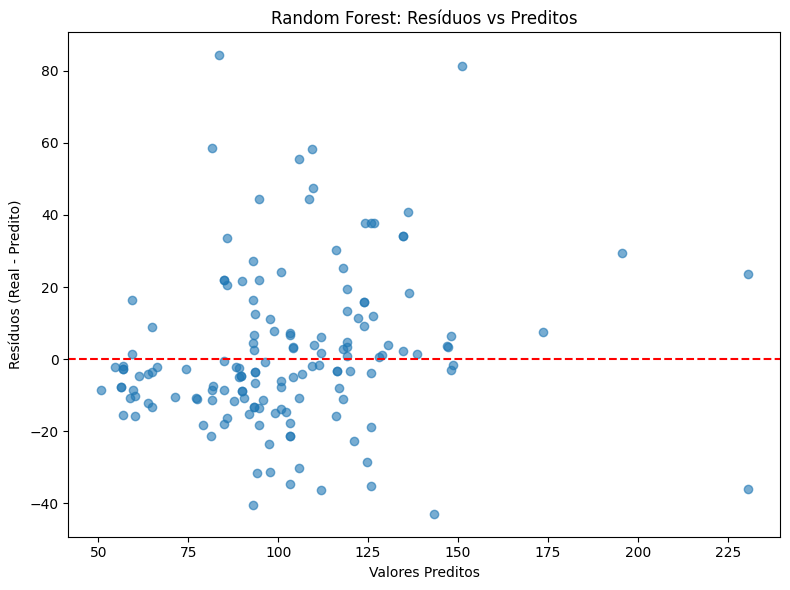

In [17]:
def plot_residuals(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred

    # Scatter
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.6)

    plt.axhline(y=0, color='red', linestyle='--')

    plt.xlabel("Valores Preditos")
    plt.ylabel("Resíduos (Real - Predito)")
    plt.title(f"{model_name}: Resíduos vs Preditos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_residuals(result, name, y_test)

#### Importância de Features

##### Árvores/Floresta (DecisionTree/RandomForest)

In [ ]:
def plot_feature_importances(result, model_name, top_n=20, text_max_len=40):
    full_pipe = result['best_estimator']
    model = full_pipe.named_steps['model'] if isinstance(full_pipe, Pipeline) else full_pipe

    # Só árvores e ensembles têm feature_importances_
    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} não tem 'feature_importances_'; pulando.")
        return

    preprocessor = full_pipe.named_steps['pipe']
    try:
        names = preprocessor.get_feature_names_out()
    except AttributeError:
        raise ValueError("O pré-processador não suporta get_feature_names_out()")

    importances = model.feature_importances_
    idx = np.argsort(importances)[-top_n:]

    # Trunca os nomes longos
    labels = [
        (names[i] if len(names[i]) <= text_max_len 
         else names[i][:text_max_len-3] + "...")
        for i in idx
    ]
    
    plt.figure(figsize=(8,6))
    plt.barh(range(top_n), importances[idx], tick_label=labels)
    plt.xlabel("Importância")
    plt.title(f"{model_name}: Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_feature_importances(result, name)

##### Modelos lineares (Lasso/Ridge)

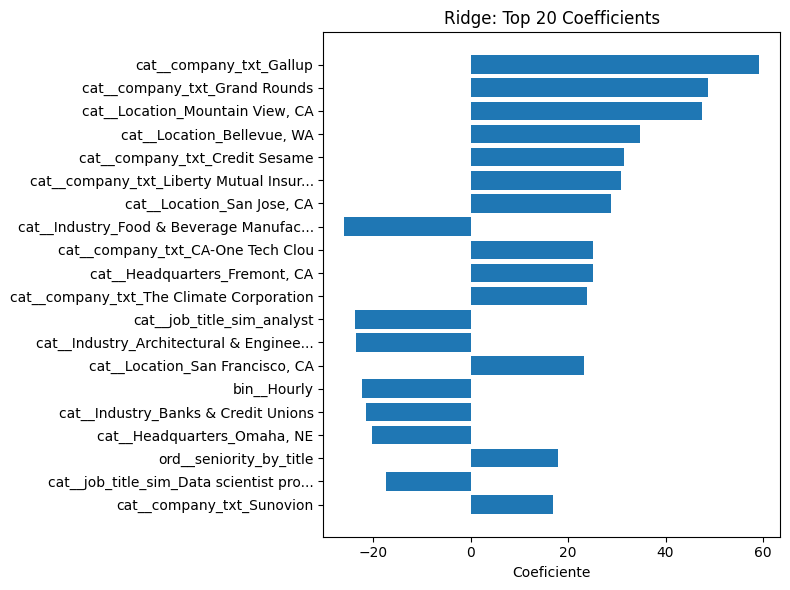

In [29]:
def plot_coefficients(result, model_name, top_n=20, text_max_len=40):
    full_pipe = result['best_estimator']
    model = full_pipe.named_steps['model'] if isinstance(full_pipe, Pipeline) else full_pipe

    # Só modelos lineares têm coef_
    if not hasattr(model, "coef_"):
        print(f"{model_name} não tem 'coef_'; pulando.")
        return

    preprocessor = full_pipe.named_steps['pipe']
    try:
        names = preprocessor.get_feature_names_out()
    except AttributeError:
        raise ValueError("O pré-processador não suporta get_feature_names_out()")

    coefs = model.coef_
    idx = np.argsort(np.abs(coefs))[-top_n:]

    # Trunca os nomes longos
    labels = [
        (names[i] if len(names[i]) <= text_max_len 
         else names[i][:text_max_len-3] + "...")
        for i in idx
    ]

    plt.figure(figsize=(8,6))    
    plt.barh(range(top_n), coefs[idx], tick_label=labels)
    plt.xlabel("Coeficiente")
    plt.title(f"{model_name}: Top {top_n} Coefficients")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
]:
    plot_coefficients(result, name)

#### Distribuição dos resíduos

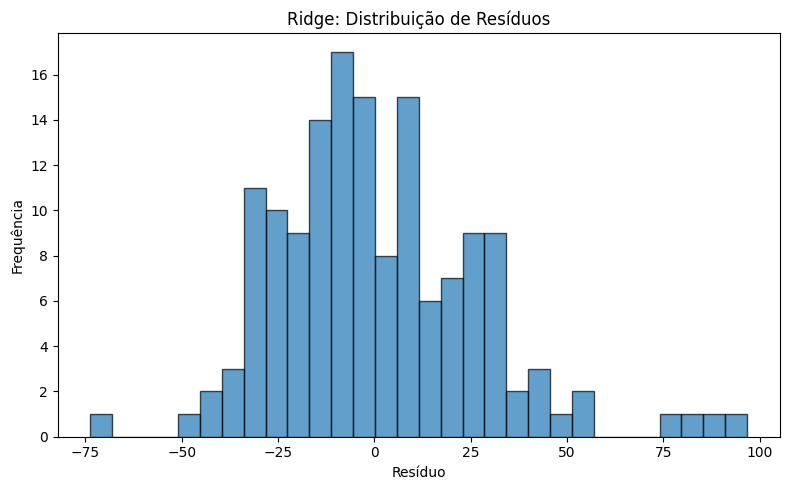

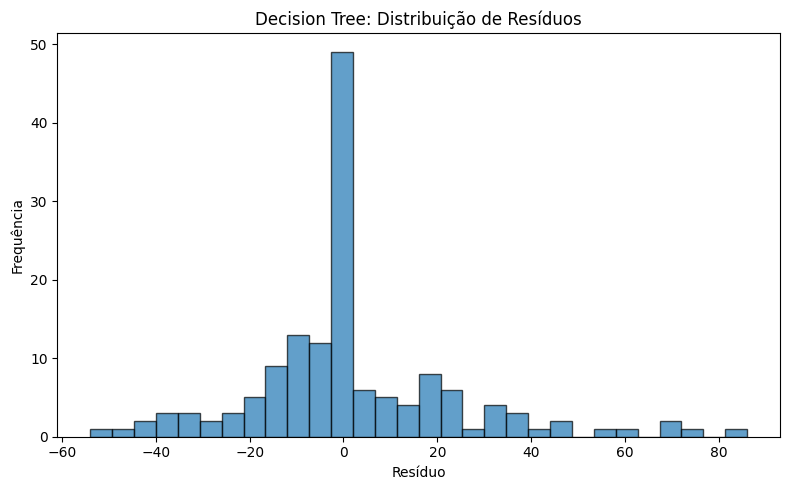

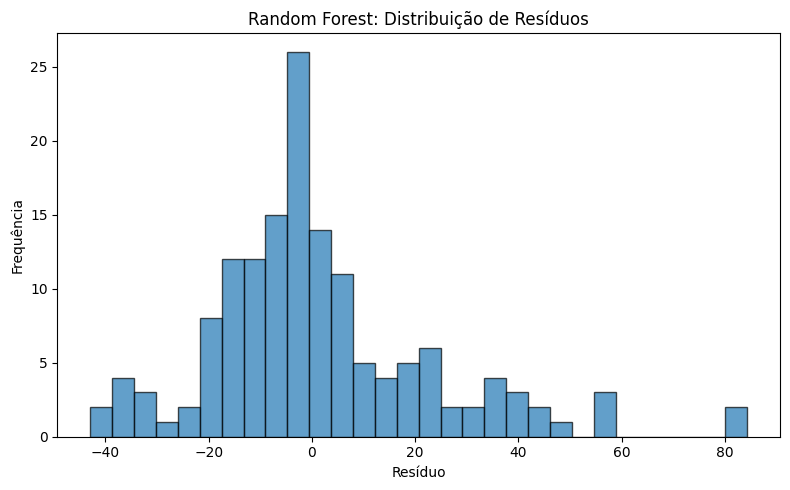

In [21]:
def plot_residuals_hist(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    plt.figure(figsize=(8,5))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.title(f"{model_name}: Distribuição de Resíduos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_residuals_hist(result, name, y_test)

#### Partial Dependence Plot

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 13 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 15 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


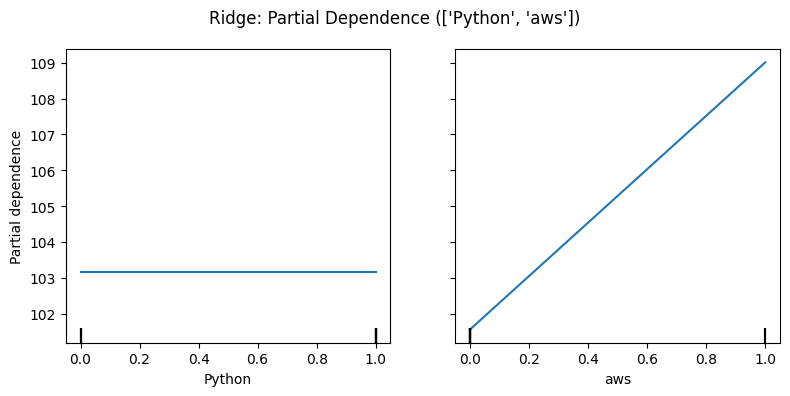

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 13 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 15 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


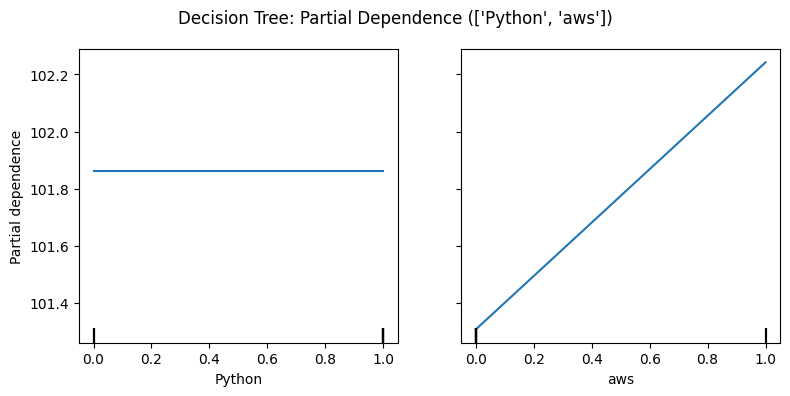

c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 13 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Washington\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 15 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


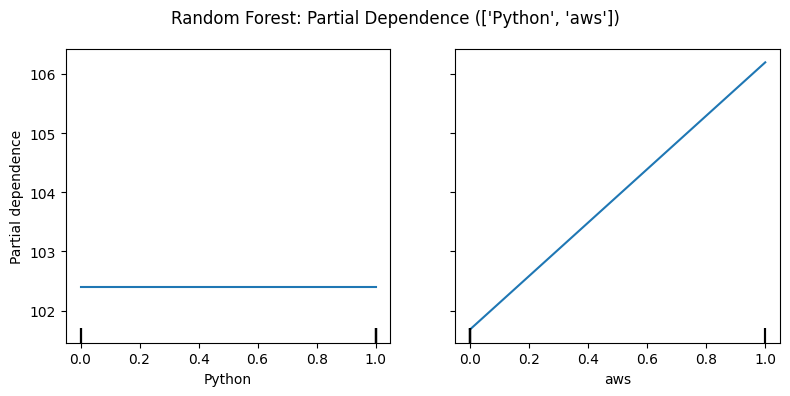

In [22]:
def plot_partial_dependence(result, model_name, X_test, features, grid_resolution=50):
    model = result['best_estimator']
    
    # Só plota se o modelo suportar predict (quase todo regressor com PDP)
    if not hasattr(model, "predict"):
        print(f"{model_name} não suporta PDP; pulando.")
        return

    # Se receber nomes de colunas, converter para índices
    feat = []
    for f in features:
        if isinstance(f, str):
            feat.append(list(X_test.columns).index(f))
        else:
            feat.append(f)


    fig, ax = plt.subplots(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        model, X_test, features=feat, ax=ax, grid_resolution=grid_resolution
    )
    plt.suptitle(f"{model_name}: Partial Dependence ({features})")
    plt.tight_layout()
    plt.show()

# Ou usando nomes de feature diretamente:
for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_partial_dependence(
        result, name, X_test, features=['Python', 'aws'], grid_resolution=50
    )

#### Pairplot

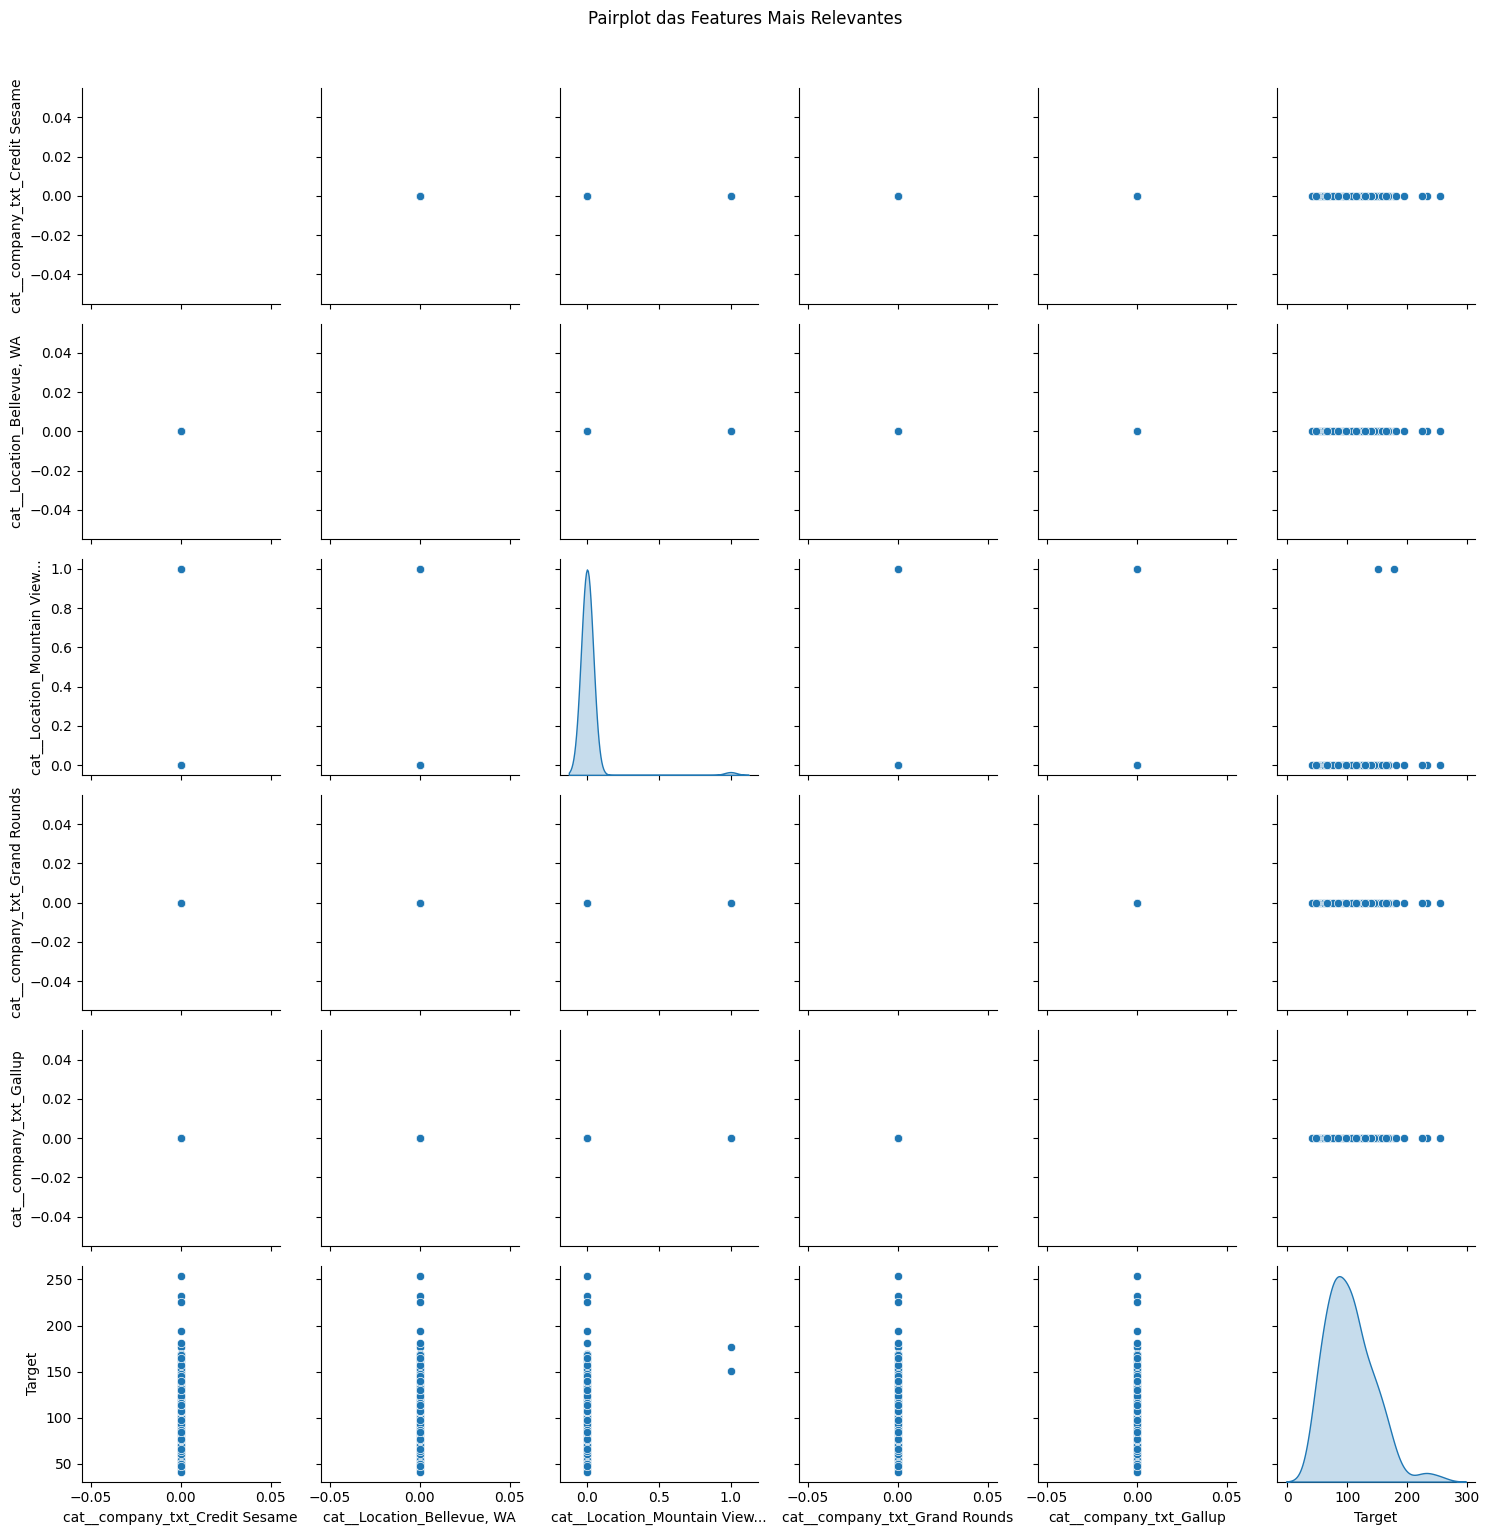

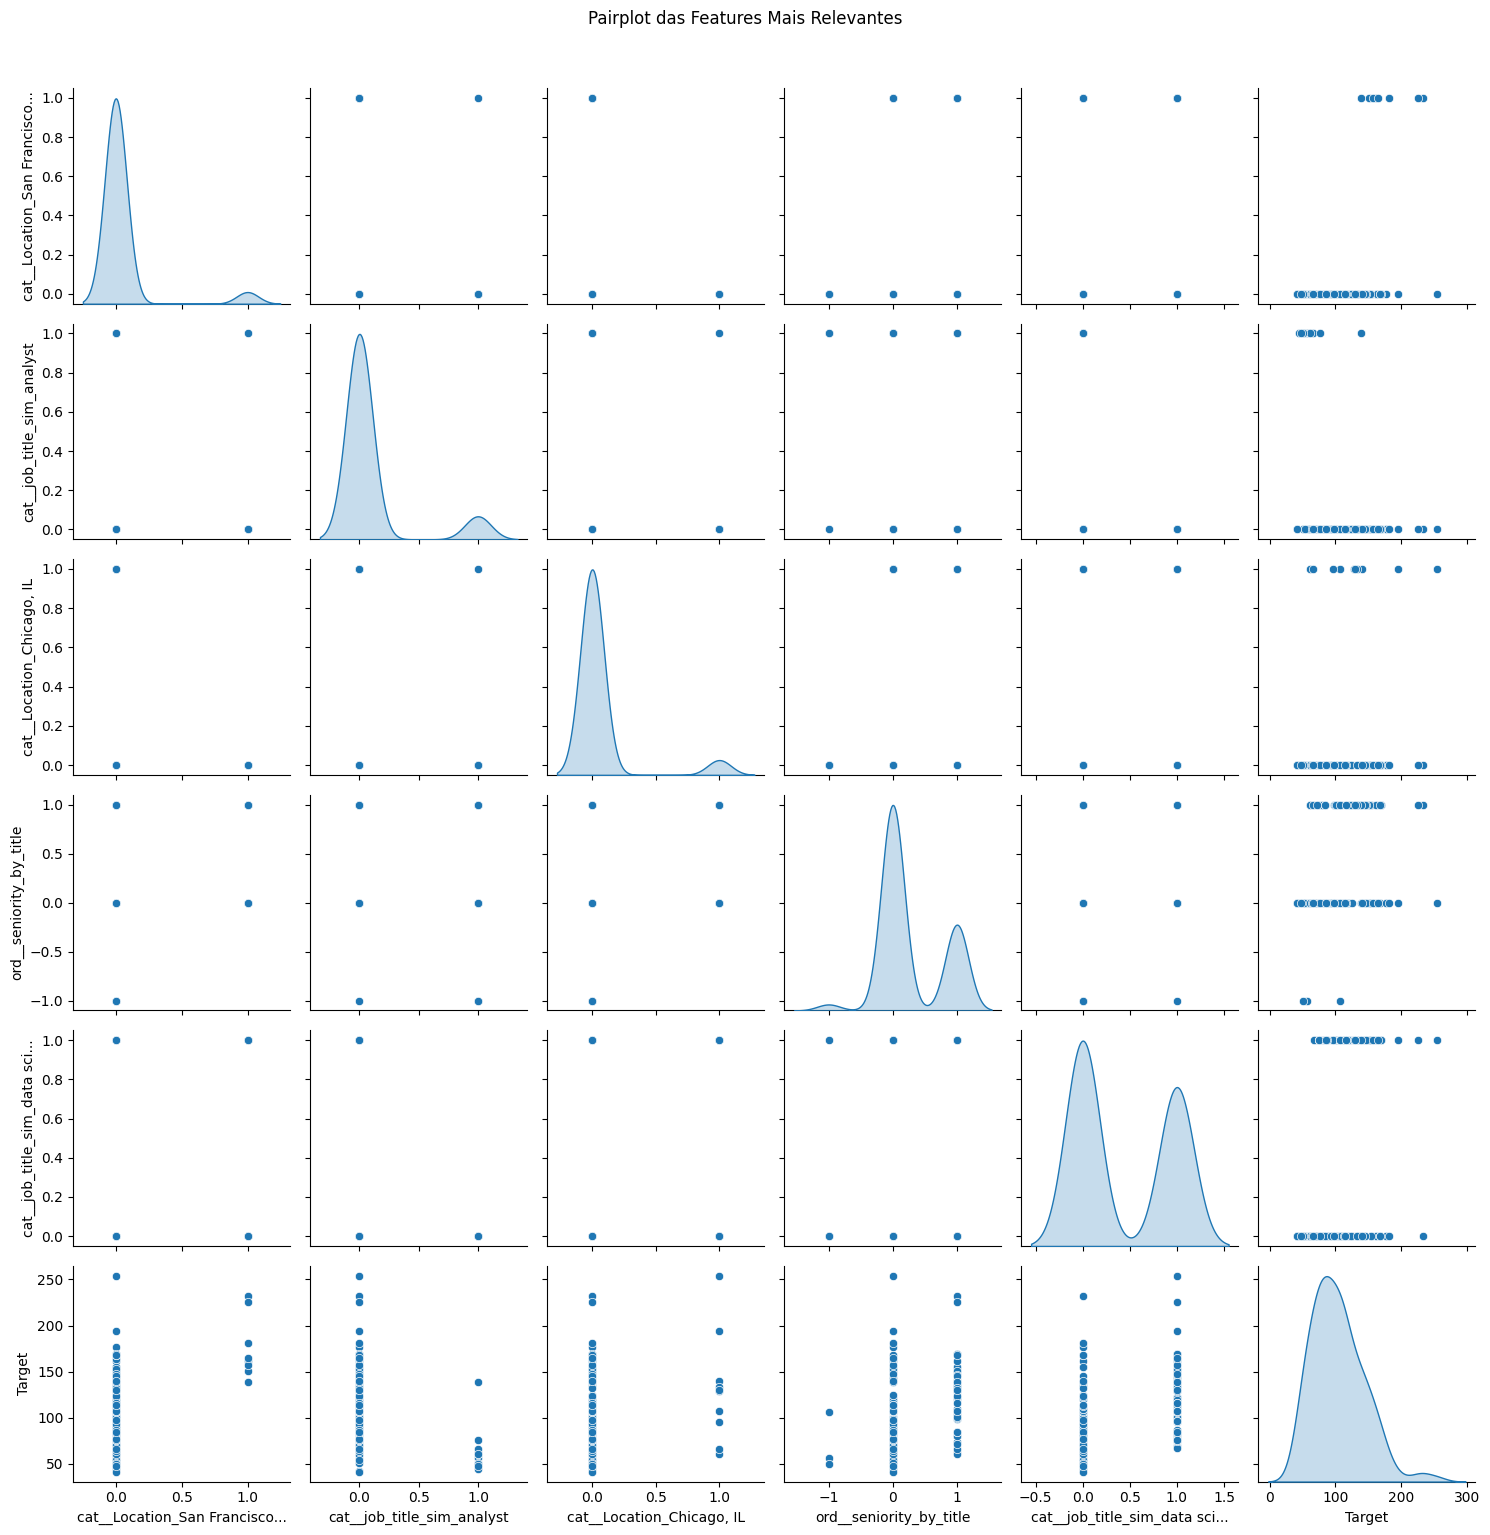

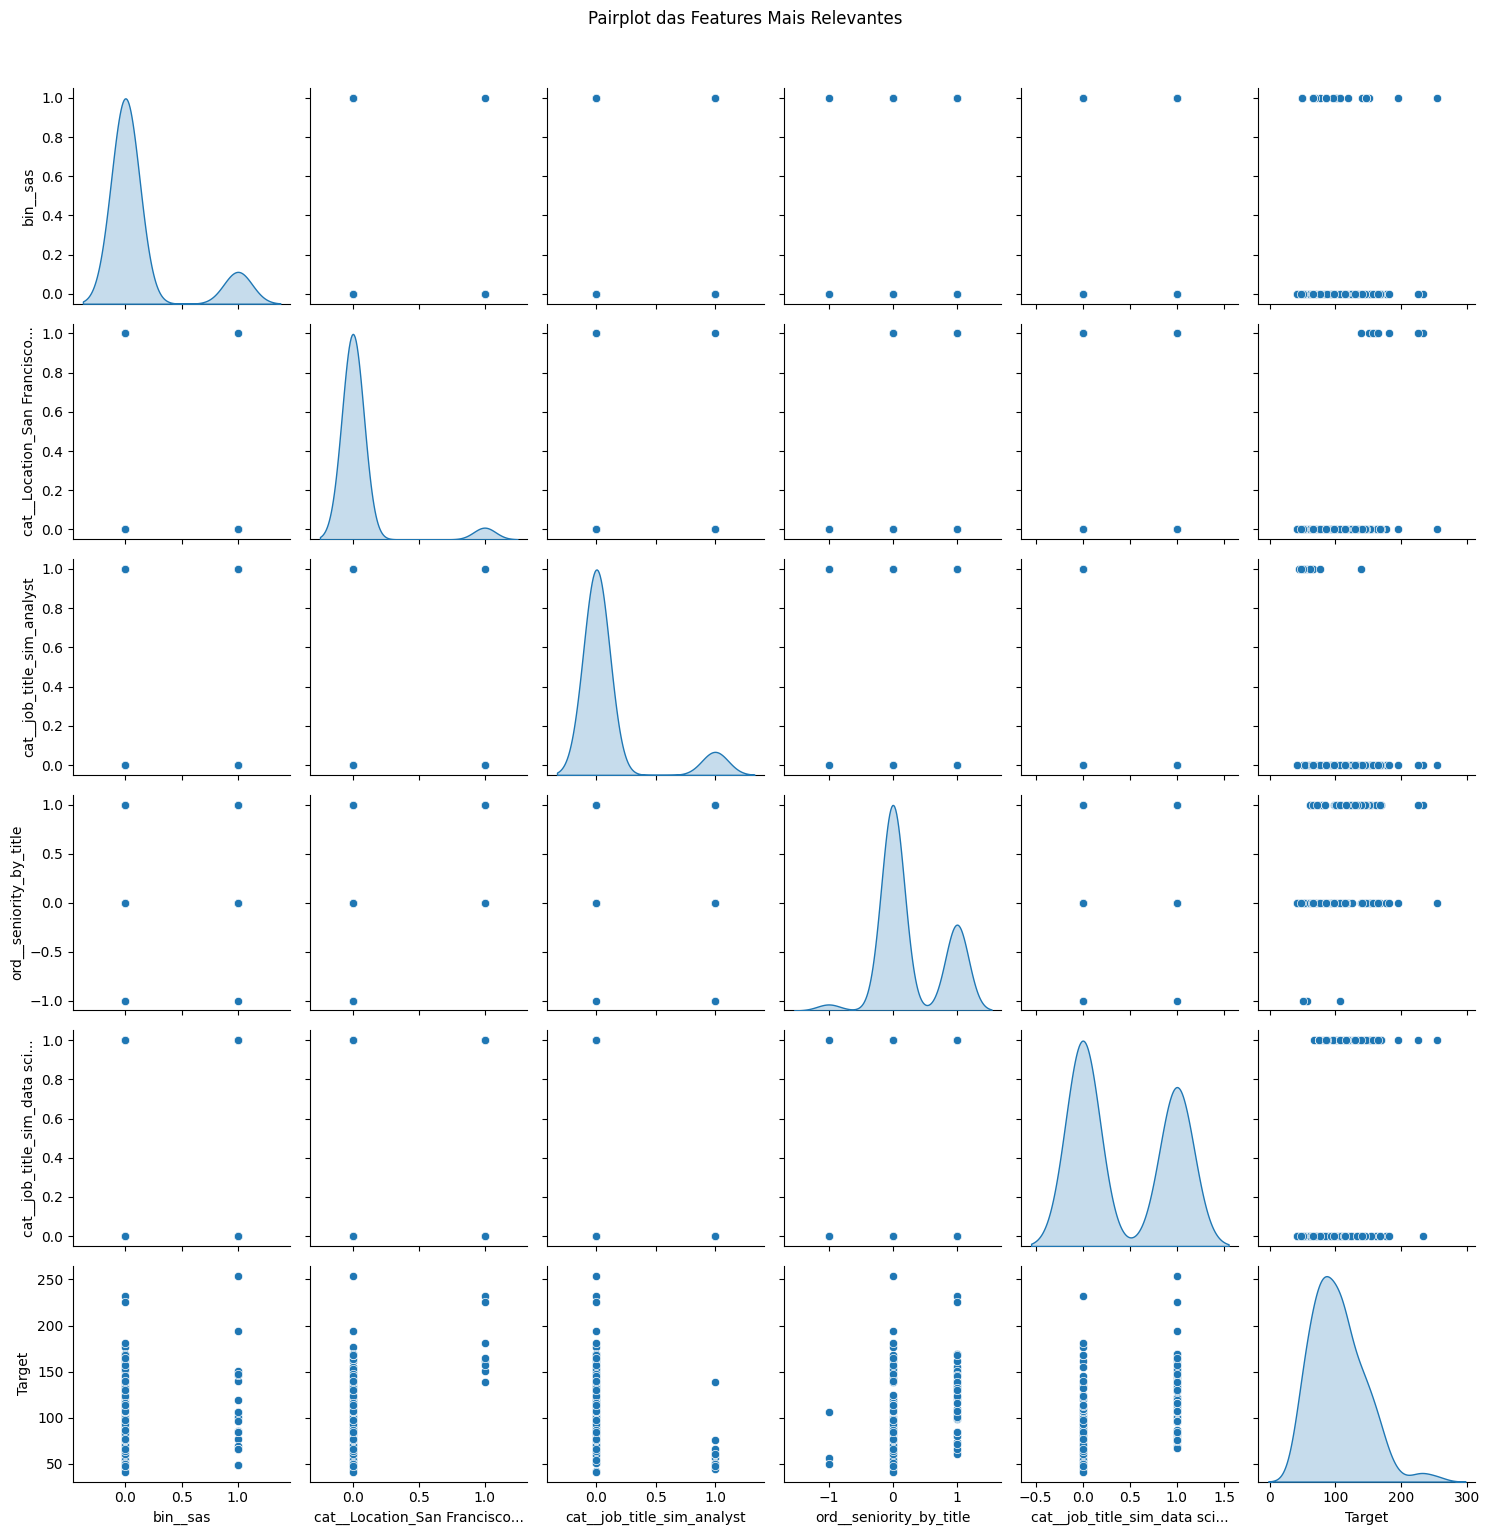

In [34]:
def plot_pairplot(result, X_test, y_test, top_n=5, text_max_len=30):    
    full_pipe = result['best_estimator']
    if not isinstance(full_pipe, Pipeline):
        raise ValueError("Resultado não contém pipeline completo com etapas 'pipe' e 'model'.")
    model = full_pipe.named_steps['model']
    pipe = full_pipe.named_steps['pipe']
    
    # Obtém importâncias ou coeficientes
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_)
    else:
        print("Modelo não tem importâncias/coefs acessíveis.")
        return

    # Extrai nomes e transforma X_test
    try:
        names = pipe.get_feature_names_out()
    except AttributeError:
        raise ValueError("O pré-processador não suporta get_feature_names_out()")
    X_sel = pipe.transform(X_test)

    idx = np.argsort(importances)[-top_n:]
    selected_features = [names[i] for i in idx]

    # Truncar nomes longos
    truncated_names = [
        (name if len(name) <= text_max_len else name[:text_max_len - 3] + "...")
        for name in selected_features
    ]

    # Converter matriz esparsa para densa se necessário
    if hasattr(X_sel, 'toarray'):
        X_sel = X_sel.toarray()

    # Criar um DataFrame com essas features + target
    data_plot = pd.DataFrame(X_sel[:, idx], columns=truncated_names)
    data_plot["Target"] = y_test.values

    # Plotar
    sns.pairplot(data_plot, diag_kind="kde")
    plt.suptitle("Pairplot das Features Mais Relevantes", y=1.02)
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_pairplot(result, X_test, y_test)

#### Curva de Aprendizado

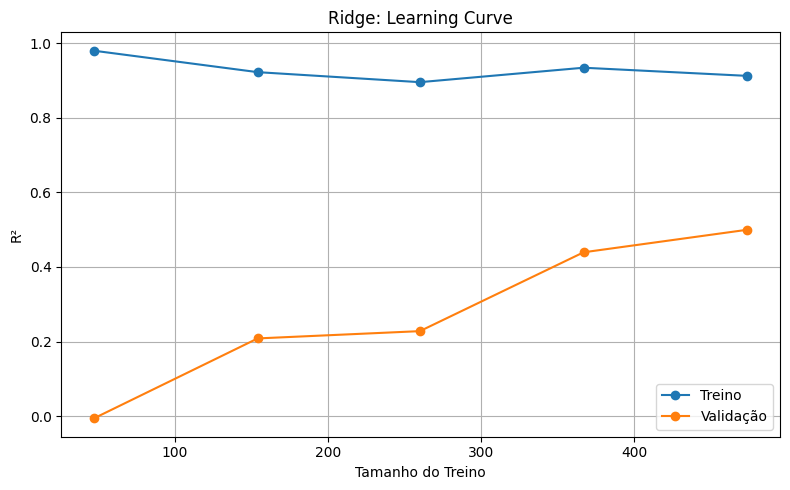

In [346]:
def plot_learning_curve(result, model_name, X_train, y_train, cv=5):
    model = result['best_estimator']

    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='r2', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean   = np.mean(val_scores,   axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Treino')
    plt.plot(train_sizes, val_mean,   'o-', label='Validação')
    plt.xlabel("Tamanho do Treino")
    plt.ylabel("R²")
    plt.title(f"{model_name}: Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    # ("Decision Tree", result_dt),
    # ("Random Forest", result_rf)
]:
    plot_learning_curve(result, name, X_train, y_train)



#### Q-Q Plot

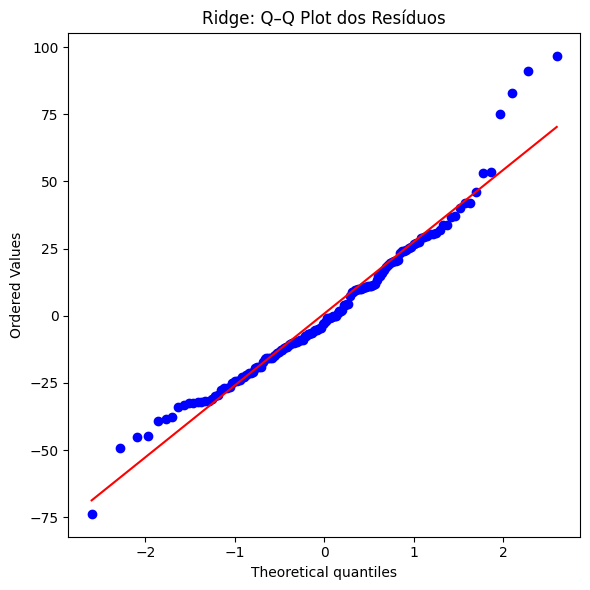

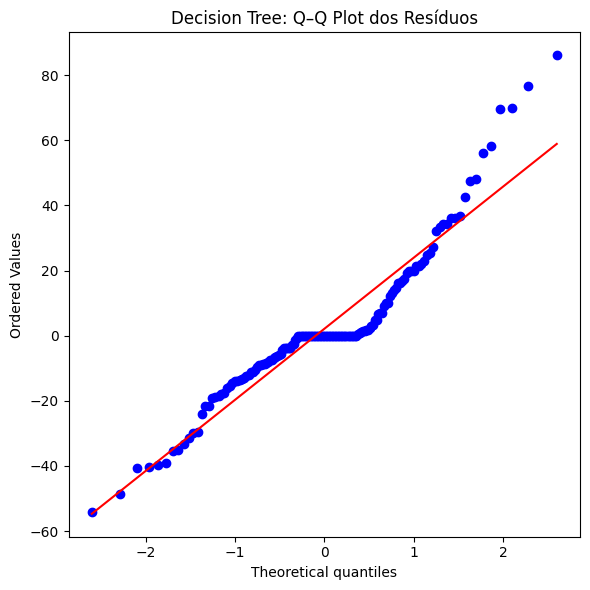

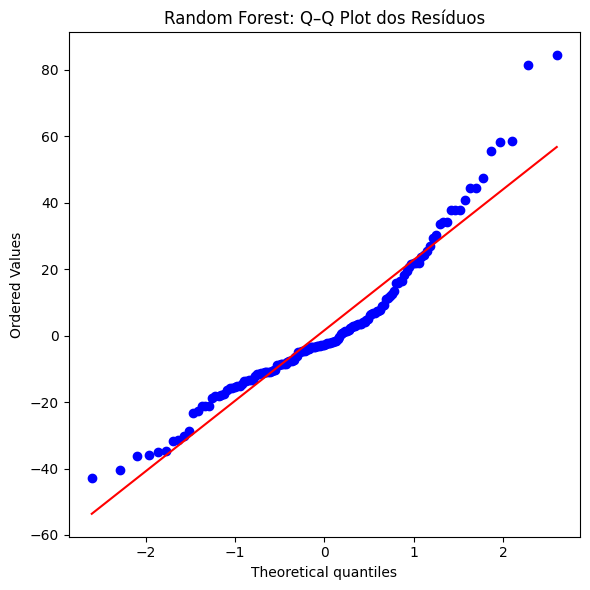

In [25]:
def plot_qq(result, model_name, y_test):
    y_pred    = result['y_pred']
    residuals = y_test - y_pred

    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{model_name}: Q–Q Plot dos Resíduos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_ridge),
    ("Decision Tree", result_dt),
    ("Random Forest", result_rf)
]:
    plot_qq(result, name, y_test)